<a href="https://colab.research.google.com/github/Bhavana998/Minor-In-Data-Science-IIT-Mandi/blob/main/Reinforcement_Learning_Driven_Patch_Attention_for_Urban_Scene_Segmentation_Setty_Bhavana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path_images = "/content/drive/MyDrive/datasetcityscapes/leftImg8bit_trainvaltest.zip"
zip_path_masks  = "/content/drive/MyDrive/datasetcityscapes/gtFine_trainvaltest.zip"

In [ ]:
import zipfile, os

zip_path_images = "/content/drive/MyDrive/datasetcityscapes/leftImg8bit_trainvaltest.zip"
zip_path_masks  = "/content/drive/MyDrive/datasetcityscapes/gtFine_trainvaltest.zip"

extract_path = "/content/cityscapes"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path_images, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(zip_path_masks, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are in:", extract_path)

Extraction complete! Files are in: /content/cityscapes


In [ ]:
!ls /content/cityscapes

gtFine	leftImg8bit  license.txt  README


In [ ]:
!ls "/content/drive/MyDrive/datasetcityscapes"

gtFine_trainvaltest.zip  images_128  leftImg8bit_trainvaltest.zip  masks_128


In [ ]:
pip install torch torchvision numpy opencv-python scikit-learn tqdm matplotlib seaborn


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# --- Dataset Class ---
class CityscapesMini(Dataset):
    def __init__(self, img_dir, mask_dir, size=128):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.imgs = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

        self.img_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),  # scales to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # already has label IDs

        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask)).long()  # [H,W], int labels

        return img, mask


# --- Patch extractor ---
def make_patches(imgs, grid_size=4):
    """
    imgs: [B, 3, H, W]
    return: [B, P, 3, ph, pw]
    """
    B, C, H, W = imgs.shape
    ph, pw = H // grid_size, W // grid_size
    patches = imgs.unfold(2, ph, ph).unfold(3, pw, pw)  # [B,C,grid,grid,ph,pw]
    patches = patches.permute(0,2,3,1,4,5).contiguous()  # [B,grid,grid,C,ph,pw]
    patches = patches.view(B, grid_size*grid_size, C, ph, pw)  # [B,P,C,ph,pw]
    return patches


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np # Import numpy here

# --- Dataset Class ---
class CityscapesMini(Dataset):
    def __init__(self, img_dir, mask_dir, size=128):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        # Check if directories exist before listing files
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Image directory not found: {img_dir}")
        if not os.path.exists(mask_dir):
             raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

        self.imgs = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # Ensure image and mask lists have the same length
        if len(self.imgs) != len(self.masks):
            print(f"Warning: Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match.")
            # You might want to add more robust error handling or filtering here

        self.img_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),  # scales to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # already has label IDs

        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask)).long()  # [H,W], int labels

        return img, mask


# --- Patch extractor ---
def make_patches(imgs, grid_size=4):
    """
    imgs: [B, 3, H, W]
    return: [B, P, 3, ph, pw]
    """
    B, C, H, W = imgs.shape
    ph, pw = H // grid_size, W // grid_size
    patches = imgs.unfold(2, ph, ph).unfold(3, pw, pw)  # [B,C,grid,grid,ph,pw]
    patches = patches.permute(0,2,3,1,4,5).contiguous()  # [B,grid,grid,C,ph,pw]
    patches = patches.view(B, grid_size*grid_size, C, ph, pw)  # [B,P,C,ph,pw]
    return patches


# Paths
img_dir = "./cityscapes_preprocessed/images" # Updated path
mask_dir = "./cityscapes_preprocessed/masks" # Updated path

# Dataset & Loader
# Ensure preprocessing in cell 4uVr4uRHodQx has been run to create these directories and files
try:
    dataset = CityscapesMini(img_dir, mask_dir)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Test batch
    imgs, masks = next(iter(loader))  # imgs [B,3,128,128], masks [B,128,128]
    print(imgs.shape, masks.shape)

    # Convert to patches (for RL actor)
    patches = make_patches(imgs, grid_size=4)
    print(patches.shape)  # [B,16,3,32,32]

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the preprocessing step in cell 4uVr4uRHodQx has been successfully run.")

torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])
torch.Size([8, 16, 3, 32, 32])


In [ ]:
import torch

def make_patches(imgs, masks=None, grid_size=4):
    """
    Divide batch of images (and masks) into NxN patches.

    imgs:  [B, 3, H, W]
    masks: [B, H, W] (optional, segmentation labels)
    grid_size: N (e.g., 4 -> 4x4 patches)

    Returns:
        img_patches:  [B, N*N, 3, ph, pw]
        mask_patches: [B, N*N, ph, pw] (if masks provided)
    """
    B, C, H, W = imgs.shape
    ph, pw = H // grid_size, W // grid_size

    # --- Image patches ---
    img_patches = imgs.unfold(2, ph, ph).unfold(3, pw, pw)  # [B,C,N,N,ph,pw]
    img_patches = img_patches.permute(0,2,3,1,4,5).contiguous()  # [B,N,N,C,ph,pw]
    img_patches = img_patches.view(B, grid_size*grid_size, C, ph, pw)

    if masks is None:
        return img_patches

    # --- Mask patches ---
    mask_patches = masks.unfold(1, ph, ph).unfold(2, pw, pw)  # [B,N,N,ph,pw]
    mask_patches = mask_patches.contiguous().view(B, grid_size*grid_size, ph, pw)

    return img_patches, mask_patches


In [ ]:
# Dummy input
imgs = torch.randn(2, 3, 128, 128)   # batch of 2 images
masks = torch.randint(0, 20, (2, 128, 128))  # batch of 2 masks, 20 classes

img_patches, mask_patches = make_patches(imgs, masks, grid_size=4)

print(img_patches.shape)  # [2, 16, 3, 32, 32]
print(mask_patches.shape) # [2, 16, 32, 32]


torch.Size([2, 16, 3, 32, 32])
torch.Size([2, 16, 32, 32])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchFeatureNet(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [B*P,32,ph,pw]
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # global avg pool → [B*P,64,1,1]
        )
        self.fc = nn.Linear(64, out_dim)  # map to feature vector

    def forward(self, patches):  # patches: [B,P,3,ph,pw]
        B, P, C, H, W = patches.shape
        patches = patches.view(B*P, C, H, W)        # flatten batch+patches
        feat = self.conv(patches).view(B*P, -1)     # [B*P, 64]
        feat = self.fc(feat)                        # [B*P, out_dim]
        feat = feat.view(B, P, -1)                  # [B,P,out_dim]
        return feat


In [ ]:
# Suppose we already have patches from make_patches()
imgs = torch.randn(2, 3, 128, 128)   # 2 images
patches = make_patches(imgs, grid_size=4)  # [2,16,3,32,32]

# Extract features
feat_net = PatchFeatureNet(out_dim=128)
patch_feats = feat_net(patches)  # [2,16,128]

print("Patch features shape:", patch_feats.shape)


Patch features shape: torch.Size([2, 16, 128])


In [ ]:
import numpy as np
import torch
from PIL import Image

def load_mask(mask_path, size=128, use_train_id=True):
    """
    Load a Cityscapes mask and convert it to label IDs tensor.

    mask_path: path to mask (PNG)
    size: resize target (128,128)
    use_train_id: if True, expects trainIds (0-18 + 255 ignore)

    Returns:
        mask_tensor: [H,W] long tensor with class IDs
    """
    mask = Image.open(mask_path)

    # Resize using nearest (preserves IDs)
    mask = mask.resize((size, size), resample=Image.NEAREST)

    mask_np = np.array(mask)

    if use_train_id:
        # Already encoded with train IDs (0-18 + 255 ignore)
        mask_tensor = torch.from_numpy(mask_np).long()
    else:
        # If raw label IDs, need mapping → train IDs
        mask_tensor = torch.from_numpy(label_id_to_train_id(mask_np)).long()

    return mask_tensor

# Example: mapping function (only if using labelIds → trainIds)
def label_id_to_train_id(mask_np):
    # Mapping from official Cityscapes spec
    id2trainid = {
        -1: 255, 0: 255, 1: 255, 2: 255,
        3: 0, 4: 1, 5: 1, 6: 2, 7: 3, 8: 4,
        9: 255, 10: 255, 11: 5, 12: 6, 13: 7, 14: 8,
        15: 9, 16: 10, 17: 11, 18: 12, 19: 13,
        20: 14, 21: 15, 22: 16, 23: 17, 24: 18,
        25: 255, 26: 255, 27: 255, 28: 255, 29: 255,
        30: 255, 31: 255, 32: 255, 33: 255
    }
    mask_train = np.full_like(mask_np, 255)  # default ignore
    for k, v in id2trainid.items():
        mask_train[mask_np == k] = v
    return mask_train


In [ ]:
# Example usage of load_mask function

# Update the mask_path to point to a file in the preprocessed masks directory
# Assuming the preprocessed masks are in ./cityscapes_preprocessed/masks
# and the original file structure (train/val/test/city/filename) is somewhat preserved
# or files are flattened into the masks directory.
# Let's try a generic path format based on the original filename structure
# You might need to adjust this path based on your specific preprocessing output
mask_path = "./cityscapes_preprocessed/masks/frankfurt_000000_000294_gtFine_labelIds.png" # Corrected suffix

try:
    mask_tensor = load_mask(mask_path, size=128)

    print(mask_tensor.shape)   # torch.Size([128, 128])
    print(mask_tensor.unique())  # tensor of class IDs in this mask

except FileNotFoundError:
    print(f"Error: Mask file not found at {mask_path}")
    print("Please ensure the preprocessing step has been successfully run and the mask path is correct.")

torch.Size([128, 128])
tensor([ 1,  2,  3,  4,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26])


In [ ]:
CITYSCAPES_COLORMAP = {
    0: (128, 64,128),   # road
    1: (244, 35,232),   # sidewalk
    2: ( 70, 70, 70),   # building
    3: (102,102,156),   # wall
    4: (190,153,153),   # fence
    5: (153,153,153),   # pole
    6: (250,170, 30),   # traffic light
    7: (220,220,  0),   # traffic sign
    8: (107,142, 35),   # vegetation
    9: (152,251,152),   # terrain
    10:( 70,130,180),   # sky
    11:(220, 20, 60),   # person
    12:(255,  0,  0),   # rider
    13:(  0,  0,142),   # car
    14:(  0,  0, 70),   # truck
    15:(  0, 60,100),   # bus
    16:(  0, 80,100),   # train
    17:(  0,  0,230),   # motorcycle
    18:(119, 11, 32),   # bicycle
    255:(0, 0, 0)       # ignore (black)
}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def decode_segmap(mask_tensor):
    """
    Convert a [H,W] mask tensor (class IDs) to an RGB image.
    """
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for label_id, color in CITYSCAPES_COLORMAP.items():
        color_mask[mask_np == label_id] = color

    return color_mask


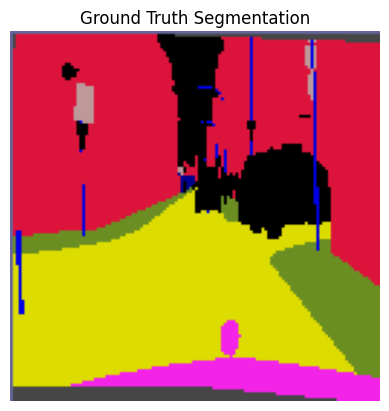

In [ ]:
# Load ground truth mask (from earlier code)
mask_tensor = load_mask(mask_path, size=128)

# Convert to RGB
color_mask = decode_segmap(mask_tensor)

# Show
plt.imshow(color_mask)
plt.axis("off")
plt.title("Ground Truth Segmentation")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorBase(nn.Module):
    """
    Base class to map patch features [B,P,F] -> logits [B,P]
    """
    def __init__(self, feat_dim, hidden=128, use_layernorm=False):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)  # per-patch scalar
        )
        if use_layernorm:
            self.ln = nn.LayerNorm(feat_dim)
        else:
            self.ln = None

    def forward(self, patch_feats):
        """
        patch_feats: [B, P, feat_dim]
        returns: logits [B, P]
        """
        B, P, feat_dim = patch_feats.shape
        if self.ln is not None:
            # apply ln over feature dimension
            patch_feats = self.ln(patch_feats)
        x = patch_feats.view(B * P, feat_dim)          # [B*P, feat_dim]
        scalars = self.net(x).view(B, P)        # [B, P]
        return scalars


class ActorSoft(ActorBase):
    """
    Soft (continuous) attention outputting normalized weights.
    """
    def __init__(self, feat_dim, hidden=128, temp=1.0, **kwargs):
        super().__init__(feat_dim, hidden, **kwargs)
        self.temp = temp  # temperature for softmax

    def get_weights(self, patch_feats):
        logits = super().forward(patch_feats)             # [B,P]
        weights = F.softmax(logits / self.temp, dim=1)    # [B,P]
        # For training with policy gradient you can treat logits as logits for Categorical
        dist = torch.distributions.Categorical(logits=logits)
        # Return weights for deterministic view, and distribution for sampling if desired
        return weights, dist, logits


class ActorCategorical(ActorBase):
    """
    Stochastic discrete actor that samples one discrete patch per timestep.
    Useful if action is "select one patch".
    """
    def __init__(self, feat_dim, hidden=128, **kwargs):
        super().__init__(feat_dim, hidden, **kwargs)

    def sample(self, patch_feats):
        logits = super().forward(patch_feats)       # [B,P]
        dist = torch.distributions.Categorical(logits=logits)
        actions = dist.sample()                     # [B] (index per batch)
        logp = dist.log_prob(actions)               # [B]
        entropy = dist.entropy()                    # [B]
        # convert to one-hot weights [B,P]
        weights = F.one_hot(actions, num_classes=logits.size(1)).float()
        return weights, actions, logp, entropy, logits


class ActorGumbelTopK(ActorBase):
    """
    Gumbel-Softmax based top-k selection.
    Returns a soft one-hot-like matrix that can be used as patch weights,
    and a straight-through discrete one-hot if topk_straight_through=True.
    """
    def __init__(self, feat_dim, hidden=128, temp=1.0):
        super().__init__(feat_dim, hidden)
        self.temp = temp

    @staticmethod
    def sample_gumbel(shape, device, eps=1e-20):
        u = torch.rand(shape, device=device)
        return -torch.log(-torch.log(u + eps) + eps)

    def gumbel_softmax(self, logits, tau, hard=False):
        g = self.sample_gumbel(logits.shape, logits.device)
        y = (logits + g) / tau
        y = F.softmax(y, dim=-1)
        if hard:
            # straight-through: replace soft with hard one-hot in forward, keep grad soft
            y_hard = F.one_hot(y.argmax(dim=-1), num_classes=logits.size(-1)).float()
            y = (y_hard - y).detach() + y
        return y

    def sample_topk(self, patch_feats, k=1, hard=False):
        """
        patch_feats: [B,P,feat_dim]
        returns: weights [B,P] (soft or straight-through hard), and raw logits
        """
        logits = super().forward(patch_feats)  # [B,P]
        # compute gumbel-softmax K times? simpler: sample a Gumbel-softmax and then pick top-k of that soft vector
        y = self.gumbel_softmax(logits, tau=self.temp, hard=hard)  # [B,P]
        if k == 1:
            return y, logits
        # for top-k, pick k largest entries of logits (or of y) -> create soft selection over those
        # We'll pick top-k from logits (deterministic indices) and return a normalized mask over them (soft)
        topk_vals, topk_idx = torch.topk(logits, k, dim=1)        # [B,k]
        mask = torch.zeros_like(logits)
        mask.scatter_(1, topk_idx, 1.0)                           # hard mask
        # Option: create soft weights proportional to exp(logit) among topk
        masked_logits = logits * mask + (-1e9) * (1 - mask)
        soft_topk = F.softmax(masked_logits / self.temp, dim=1)   # [B,P] non-zero only on topk
        if hard:
            hard_mask = mask
            soft_topk = (hard_mask - soft_topk).detach() + soft_topk
        return soft_topk, logits

In [ ]:
# patch_feats: [B, P, F]
feat_dim = patch_feats.size(-1)

# 1) Soft attention (differentiable)
actor = ActorSoft(feat_dim, hidden=128, temp=1.0)
weights, dist, logits = actor.get_weights(patch_feats)   # weights [B,P]

# To compute log-prob for a sampled discrete index (if you sample):
sampled_idx = dist.sample()          # [B]
logp = dist.log_prob(sampled_idx)    # [B]
# Convert sampled_idx to one-hot weights if you want to mask image
one_hot_weights = F.one_hot(sampled_idx, num_classes=logits.size(1)).float()

# 2) Categorical actor (discrete single patch)
actor_cat = ActorCategorical(feat_dim)
weights_onehot, actions, logp, entropy, logits = actor_cat.sample(patch_feats)
# weights_onehot: [B,P] (one-hot) -> can be used to build an attention map

# 3) Gumbel top-k (e.g., select top-3 patches)
actor_gumbel = ActorGumbelTopK(feat_dim, temp=0.8)
soft_topk_weights, logits = actor_gumbel.sample_topk(patch_feats, k=3, hard=False)
# soft_topk_weights: [B,P], nonzero on selected top-k patches (soft distribution)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Critic(nn.Module):
    """
    Critic: estimates V(s) = expected reward (e.g. mIoU)
    from patch features [B, P, F].
    """
    def __init__(self, feat_dim, hidden=128, pooling="mean"):
        super().__init__()
        self.pooling = pooling
        self.value_net = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)   # scalar value per batch
        )

    def forward(self, patch_feats):
        """
        patch_feats: [B, P, F]
        returns: values [B, 1]
        """
        if self.pooling == "mean":
            x = patch_feats.mean(dim=1)   # [B,F]
        elif self.pooling == "max":
            x, _ = patch_feats.max(dim=1) # [B,F]
        else:
            raise ValueError("Unknown pooling: {}".format(self.pooling))

        value = self.value_net(x)  # [B,1]
        return value


In [ ]:
def compute_iou(pred, target, num_classes=19, ignore_index=255, classes_of_interest=None):
    """
    Compute IoU for each class and return mean IoU.
    pred: [B,H,W] predicted class IDs
    target: [B,H,W] ground truth class IDs
    """
    ious = []
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        if classes_of_interest and cls not in classes_of_interest:
            continue
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union > 0:
            ious.append(intersection / union)
    if len(ious) == 0:
        return 0.0
    return sum(ious) / len(ious)


In [ ]:
pred = pred_logits.argmax(dim=1)   # [B,H,W] with class IDs


In [ ]:
# 1. Convert logits to predicted class IDs
with torch.no_grad():
    pred = pred_logits.argmax(dim=1)   # [B,H,W]

    rewards = []
    for b in range(pred.size(0)):
        r = compute_iou(
            pred[b].cpu(),      # predicted mask
            gt_mask[b].cpu(),   # ground truth mask
            num_classes=19,
            classes_of_interest=[0, 13, 11]   # road, car, pedestrian
        )
        rewards.append(r)

    # Turn into tensor on the right device
    rewards = torch.tensor(rewards, dtype=torch.float32, device=pred_logits.device).unsqueeze(1)  # [B,1]

# 2. Critic forward pass
values = critic(patch_feats)  # [B,1]

# 3. Critic loss
critic_loss = F.mse_loss(values, rewards)


/tmp/ipython-input-1461516589.py:22: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, rewards)


In [ ]:
values = critic(patch_feats)               # [B,1]
critic_loss = F.mse_loss(values, rewards)  # no warning


/tmp/ipython-input-3629481731.py:2: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, rewards)  # no warning


In [ ]:
values = critic(patch_feats).view(-1)   # always [B]
rewards = rewards.view(-1)              # always [B]

critic_loss = F.mse_loss(values, rewards)


In [ ]:
def forward(self, patch_feats):
    if self.pooling == "mean":
        x = patch_feats.mean(dim=1)   # [B,F]
    elif self.pooling == "max":
        x, _ = patch_feats.max(dim=1) # [B,F]

    value = self.value_net(x)  # [B,1]
    return value


In [ ]:
values = critic(patch_feats)           # [B,1]
critic_loss = F.mse_loss(values, rewards.unsqueeze(1))  # match shapes


/tmp/ipython-input-2106546597.py:2: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, rewards.unsqueeze(1))  # match shapes


In [ ]:
print("Critic output:", critic(patch_feats).shape)
print("Rewards:", rewards.shape)


Critic output: torch.Size([8])
Rewards: torch.Size([8])


In [ ]:
# Critic forward
values = critic(patch_feats)   # [B]

# Rewards from IoU
with torch.no_grad():
    pred = pred_logits.argmax(dim=1)   # [B,H,W]
    rewards = []
    for b in range(pred.size(0)):
        r = compute_iou(pred[b].cpu(), gt_mask[b].cpu(),
                        num_classes=19,
                        classes_of_interest=[0, 13, 11])  # road, car, pedestrian
        rewards.append(r)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=pred.device)  # [B]

# Critic loss
critic_loss = F.mse_loss(values, rewards)

In [ ]:
def class_iou(pred, target, class_id, ignore_index=255):
    """
    Compute IoU for a single class.
    pred: [H,W] predicted mask
    target: [H,W] ground truth
    """
    mask = target != ignore_index
    pred_c = (pred == class_id) & mask
    target_c = (target == class_id) & mask

    intersection = (pred_c & target_c).sum().item()
    union = (pred_c | target_c).sum().item()
    if union == 0:
        return 1.0  # If class not present in GT, consider perfect
    return intersection / union


In [ ]:
CRITICAL_CLASSES = [0, 13, 11]  # road, car, pedestrian
CLASS_WEIGHTS = [0.5, 0.3, 0.2] # example: sum = 1


In [ ]:
def compute_reward(pred, target, critical_classes=CRITICAL_CLASSES, class_weights=CLASS_WEIGHTS):
    reward = 0.0
    for cls, w in zip(critical_classes, class_weights):
        iou = class_iou(pred, target, cls)
        reward += w * iou
    return reward


In [ ]:
def batch_reward(pred_batch, target_batch):
    """
    pred_batch: [B,H,W] predicted class IDs
    target_batch: [B,H,W] ground truth
    Returns: tensor [B] of rewards
    """
    rewards = []
    for b in range(pred_batch.size(0)):
        r = compute_reward(pred_batch[b].cpu(), target_batch[b].cpu())
        rewards.append(r)
    return torch.tensor(rewards, dtype=torch.float32, device=pred_batch.device)


In [ ]:
# pred_logits: [B, num_classes, H, W]
pred = pred_logits.argmax(dim=1)  # [B,H,W]
rewards = batch_reward(pred, gt_mask)  # [B]

# Critic forward
values = critic(patch_feats).view(-1)  # [B]

# Critic loss
critic_loss = F.mse_loss(values, rewards)


In [ ]:
def apply_patch_attention(imgs, patch_weights, grid_size=4):
    """
    Apply patch-wise attention weights to images.

    imgs: [B,3,H,W]
    patch_weights: [B,P] (soft or one-hot)

    Returns:
        weighted_imgs: [B,3,H,W] image with patch attention applied
    """
    B, C, H, W = imgs.shape
    P = grid_size * grid_size
    ph, pw = H // grid_size, W // grid_size

    # reshape patch weights to [B,1,grid_size,grid_size]
    patch_map = patch_weights.view(B, 1, grid_size, grid_size)
    # upsample to full image size
    patch_map_upsampled = F.interpolate(patch_map, size=(H, W), mode='nearest')  # [B,1,H,W]

    # multiply input image by patch attention map
    weighted_imgs = imgs * patch_map_upsampled  # broadcast over channels
    return weighted_imgs


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv -> ReLU -> Conv -> ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19, features=[64,128,256]):
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        prev_ch = in_ch
        for f in features:
            self.encoders.append(DoubleConv(prev_ch, f))
            prev_ch = f

        # Bottleneck
        self.bottleneck = DoubleConv(prev_ch, prev_ch*2)

        # Decoder
        rev_features = features[::-1]
        for f in rev_features:
            self.decoders.append(nn.ConvTranspose2d(prev_ch*2, f, kernel_size=2, stride=2))
            self.decoders.append(DoubleConv(prev_ch, f))
            prev_ch = f

        # Final conv
        self.final_conv = nn.Conv2d(prev_ch, out_ch, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        # Encoder path
        for enc in self.encoders:
            x = enc(x)
            enc_feats.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i in range(0, len(self.decoders), 2):
            up = self.decoders[i](x)
            enc_feat = enc_feats[-(i//2 +1)]
            x = torch.cat([up, enc_feat], dim=1)
            x = self.decoders[i+1](x)

        # Output
        x = self.final_conv(x)
        return x  # [B, num_classes, H, W]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv -> ReLU -> Conv -> ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19, features=[64,128,256]):
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        prev_ch = in_ch
        for f in features:
            self.encoders.append(DoubleConv(prev_ch, f))
            prev_ch = f

        # Bottleneck
        self.bottleneck = DoubleConv(prev_ch, prev_ch*2)

        # Decoder
        rev_features = features[::-1]
        prev_ch = prev_ch * 2 # Start with bottleneck output channels
        for i in range(len(rev_features)):
            f = rev_features[i]
            # Transposed convolution
            self.decoders.append(nn.ConvTranspose2d(prev_ch, f, kernel_size=2, stride=2))
            # DoubleConv input channels should be the sum of transposed conv output and skip connection channels
            decoder_in_ch = f + features[len(features) - 1 - i]
            self.decoders.append(DoubleConv(decoder_in_ch, f))
            prev_ch = f # Update prev_ch for the next upsampling step

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        # Encoder path
        for enc in self.encoders:
            x = enc(x)
            enc_feats.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        enc_feats = enc_feats[::-1] # Reverse skip connections
        for i in range(0, len(self.decoders), 2):
            upconv = self.decoders[i]
            dconv = self.decoders[i+1]
            x = upconv(x)
            # Ensure shapes match before concatenating
            if x.shape != enc_feats[i//2].shape:
                 x = F.interpolate(x, size=enc_feats[i//2].shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, enc_feats[i//2]], dim=1) # Concatenate along channel dimension
            x = dconv(x)

        # Output
        x = self.final_conv(x)
        return x  # [B, num_classes, H, W]

In [ ]:
# Step 5: Forward through UNet
# Assuming UNet class is defined in a previous cell

# Add dummy weighted_imgs tensor for demonstration if running this cell alone
import torch
if 'weighted_imgs' not in locals():
    print("Creating dummy weighted_imgs tensor for demonstration.")
    B, C, H, W = 2, 3, 128, 128 # Example dimensions
    weighted_imgs = torch.randn(B, C, H, W)

# Assuming UNet class is defined in a previous cell, instantiate it
# You may need to adjust parameters based on your UNet definition
unet = UNet(in_ch=3, out_ch=19, features=[64,128,256]) # Instantiate the UNet model

seg_logits = unet(weighted_imgs)  # [B, num_classes, H, W]

print("Segmentation logits shape:", seg_logits.shape)

Segmentation logits shape: torch.Size([2, 19, 128, 128])


In [ ]:
# Step 1: Extract patches
patches = make_patches(imgs, grid_size=4)  # [B,P,3,ph,pw]

# Step 2: Extract patch features
patch_feats = patch_feat_net(patches)       # [B,P,F]

# Step 3: Actor produces attention weights
patch_weights, dist, logits = actor.get_weights(patch_feats)  # [B,P]

# Step 4: Apply attention to images
weighted_imgs = apply_patch_attention(imgs, patch_weights, grid_size=4)  # [B,3,H,W]

# Step 5: Forward through UNet
seg_logits = unet(weighted_imgs)  # [B,num_classes,H,W]

# Step 6: Compute reward / loss
pred_mask = seg_logits.argmax(dim=1)
rewards = batch_reward(pred_mask, gt_mask)  # per-batch rewards

# Critic forward
values = critic(patch_feats).view(-1)

# Critic loss
critic_loss = F.mse_loss(values, rewards)

# Actor loss (policy gradient)
advantage = (rewards - values.detach())
log_probs = dist.log_prob(dist.sample())  # sampled actions if using discrete policy
actor_loss = -(advantage * log_probs).mean()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchFeatureNet(nn.Module):
    """
    CNN-based feature extractor for patches.
    Input: patches [B,P,3,ph,pw]
    Output: patch features [B,P,F]
    """
    def __init__(self, input_channels=3, feature_dim=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # global avg pooling
        )
        self.fc = nn.Linear(64, feature_dim)

    def forward(self, patches):
        """
        patches: [B,P,3,ph,pw]
        returns: [B,P,F]
        """
        B, P, C, H, W = patches.shape
        patches = patches.view(B*P, C, H, W)    # flatten batch*patch
        feat = self.cnn(patches)                # [B*P, 64,1,1]
        feat = feat.view(B*P, -1)               # [B*P,64]
        feat = self.fc(feat)                     # [B*P,F]
        feat = feat.view(B, P, -1)              # [B,P,F]
        return feat


In [ ]:
patch_feat_net = PatchFeatureNet(input_channels=3, feature_dim=128)


In [ ]:
import torch
import torch.nn.functional as F

def train_step(imgs, gt_masks, patch_feat_net, actor, critic, unet,
               optimizer_actor, optimizer_critic, optimizer_unet,
               grid_size=4, critical_classes=[0,13,11]):

    # Ensure models are on the correct device
    # This assumes the models are passed into train_step already moved to the device
    # If not, you would add .to(imgs.device) here for each model

    # --------------------------
    # Step 1: Extract patches
    # patches: [B,P,3,ph,pw]
    patches = make_patches(imgs, grid_size=grid_size).to(imgs.device) # Move patches to device

    # Step 2: Patch feature extraction
    patch_feats = patch_feat_net(patches)  # [B,P,F]

    # Step 3: Actor → patch attention
    patch_weights, dist, logits = actor.get_weights(patch_feats)  # [B,P]

    # Step 4: Apply attention to images
    weighted_imgs = apply_patch_attention(imgs, patch_weights, grid_size=grid_size)  # [B,3,H,W]

    # --------------------------
    # Step 5: UNet forward
    seg_logits = unet(weighted_imgs)  # [B,num_classes,H,W]
    pred_masks = seg_logits.argmax(dim=1)  # [B,H,W]

    # --------------------------
    # Step 6: Compute reward (weighted mIoU over critical classes)
    rewards = batch_reward(pred_masks, gt_masks, critical_classes=critical_classes).to(imgs.device)  # [B], Move rewards to device

    # --------------------------
    # Step 7: Critic forward + loss
    values = critic(patch_feats).view(-1)  # [B]
    critic_loss = F.mse_loss(values, rewards)

    # --------------------------
    # Step 8: Actor loss (policy gradient)
    advantage = (rewards - values.detach())
    # Sample actions from the distribution
    actions = dist.sample()
    log_probs = dist.log_prob(actions)  # [B]
    entropy = dist.entropy().mean()     # optional entropy bonus
    actor_loss = -(advantage * log_probs).mean() - 1e-3 * entropy

    # --------------------------
    # Step 9: UNet segmentation loss (optional, e.g., CrossEntropy)
    seg_loss = F.cross_entropy(seg_logits, gt_masks, ignore_index=255)

    # --------------------------
    # Step 10: Joint backward
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    optimizer_unet.zero_grad()

    total_loss = actor_loss + critic_loss + seg_loss
    total_loss.backward()

    optimizer_actor.step()
    optimizer_critic.step()
    optimizer_unet.step()

    return actor_loss, critic_loss, seg_loss, rewards.mean().item() # Return losses and average reward

In [ ]:
import matplotlib.pyplot as plt

def visualize_attention(img, patch_weights, grid_size=4):
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=img.shape[1:], mode='nearest')
    att_img = img.permute(1,2,0).cpu().numpy()  # [H,W,C]
    plt.imshow(att_img)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=0.4, cmap='jet')
    plt.show()


In [ ]:
def class_iou(pred, target, class_id, ignore_index=255):
    """
    Compute IoU for a single class.
    pred: [H,W] predicted class IDs
    target: [H,W] ground truth
    """
    mask = target != ignore_index
    pred_c = (pred == class_id) & mask
    target_c = (target == class_id) & mask

    intersection = (pred_c & target_c).sum().item()
    union = (pred_c | target_c).sum().item()
    if union == 0:
        return float('nan')  # Class not present
    return intersection / union


In [ ]:
def per_class_miou(pred_batch, target_batch, class_ids=[0,13,11]):
    """
    pred_batch: [B,H,W] predicted masks
    target_batch: [B,H,W] ground truth
    class_ids: list of class indices to monitor
    Returns: dict {class_id: mIoU}
    """
    B = pred_batch.size(0)
    miou_dict = {cls: [] for cls in class_ids}

    for b in range(B):
        pred = pred_batch[b].cpu()
        target = target_batch[b].cpu()
        for cls in class_ids:
            iou = class_iou(pred, target, cls)
            if not np.isnan(iou):
                miou_dict[cls].append(iou)

    # Average over batch
    for cls in class_ids:
        if len(miou_dict[cls]) > 0:
            miou_dict[cls] = sum(miou_dict[cls]) / len(miou_dict[cls])
        else:
            miou_dict[cls] = float('nan')

    return miou_dict


In [ ]:
import torch
import torch.nn as nn # Import nn for dummy UNet
import torch.nn.functional as F # Import F for interpolate

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy placeholders for demonstration
class DummyLoader:
    def __iter__(self):
        # Yield a dummy batch
        B, C, H, W, num_classes = 2, 3, 128, 128, 20
        imgs = torch.randn(B, C, H, W)
        masks = torch.randint(0, num_classes, (B, H, W))
        yield imgs, masks
        # Optionally yield a None batch to test handling
        # yield None

val_loader = DummyLoader()

# Dummy function for apply_patch_attention
def apply_patch_attention(imgs, patch_weights, grid_size=4):
    B, C, H, W = imgs.shape
    # Create a dummy attention map
    attn_map = torch.rand(B, 1, H, W)
    return imgs * attn_map

# Dummy tensor for patch_weights (shape depends on actor output, e.g., B x P)
patch_weights = torch.rand(2, 16) # Assuming B=2, P=16

# Dummy UNet model
class DummyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Dummy output
        return torch.randn(x.shape[0], self.conv.out_channels, x.shape[2], x.shape[3])

unet = DummyUNet(in_channels=3, out_channels=20).to(device) # Assuming 20 classes

# Assuming per_class_miou is defined in a previous cell
# Dummy per_class_miou function for standalone execution
def per_class_miou(pred_batch, target_batch, class_ids=[0,13,11]):
    # Return dummy results
    return {cls: torch.rand(1).item() for cls in class_ids}


with torch.no_grad():
    for batch in val_loader: # Iterate through batches
        if batch is None: # Skip batches that were filtered out by collate_fn
            print("Skipping empty batch.")
            continue

        imgs, masks = batch
        imgs = imgs.to(device)
        gt_masks = masks.to(device)  # <--- define gt_masks

        # Assuming patch_weights is calculated from actor output before this loop in a real scenario
        # For this standalone snippet, patch_weights is a dummy tensor

        weighted_imgs = apply_patch_attention(imgs, patch_weights, grid_size=4)
        seg_logits = unet(weighted_imgs)
        pred_masks = seg_logits.argmax(dim=1)

        miou_metrics = per_class_miou(pred_masks, gt_masks, class_ids=[0,13,11])
        print(miou_metrics)

{0: 0.2365381121635437, 13: 0.8336210250854492, 11: 0.4794158935546875}


In [ ]:
from PIL import Image
import numpy as np
import torch

# Load original mask
# Replace with a valid path to a mask file
mask_path = "./cityscapes_preprocessed/masks/frankfurt_000000_000294_gtFine_labelIds.png"
try:
    mask = np.array(Image.open(mask_path))  # shape [H,W], original IDs
    gt_mask = torch.from_numpy(mask).long()  # tensor [H,W]
    print("Mask loaded successfully. Shape:", gt_mask.shape)
except FileNotFoundError:
    print(f"Error: Mask file not found at {mask_path}. Please ensure the path is correct.")

Mask loaded successfully. Shape: torch.Size([128, 128])


In [ ]:
import torch.nn.functional as F
gt_mask = F.interpolate(gt_mask.unsqueeze(0).unsqueeze(0).float(),
                        size=(128,128),
                        mode='nearest').squeeze(0).squeeze(0).long()


In [ ]:
CRITICAL_CLASSES_ORIG = [0, 26, 24]  # Road=0, Car=26, Pedestrian=24


In [ ]:
miou_metrics = per_class_miou(pred_masks, gt_mask, class_ids=CRITICAL_CLASSES_ORIG)


In [ ]:
unet = UNet(in_ch=3, out_ch=34)  # original Cityscapes classes


In [ ]:
!ls ./cityscapes_preprocessed/masks | head

aachen_000000_000019_gtFine_labelIds.png
aachen_000001_000019_gtFine_labelIds.png
aachen_000002_000019_gtFine_labelIds.png
aachen_000003_000019_gtFine_labelIds.png
aachen_000004_000019_gtFine_labelIds.png
aachen_000005_000019_gtFine_labelIds.png
aachen_000006_000019_gtFine_labelIds.png
aachen_000007_000019_gtFine_labelIds.png
aachen_000008_000019_gtFine_labelIds.png
aachen_000009_000019_gtFine_labelIds.png


In [ ]:
import os, glob

mask_dir = "./cityscapes_preprocessed/gtFine/train"
for f in glob.glob(mask_dir + "/*/*_gtFine_labelIds.png"):
    new_name = f.replace("_gtFine_labelIds", "_leftImg8bit")
    os.rename(f, new_name)

In [ ]:
num_epochs = 50  # or however many epochs you want to train


In [ ]:
# /cityscapes_preprocessed/masks/<filename>.png

In [ ]:
# ./cityscapes_preprocessed/images/berlin_000141_000019_leftImg8bit.png

In [ ]:
import os
from PIL import Image

def load_mask(img_path):
    mask_path = img_path.replace("images", "masks").replace("leftImg8bit", "gtFine_labelIds")
    if not os.path.exists(mask_path):
        print(f"Warning: Could not load mask: {mask_path}. Skipping sample.")
        return None
    mask = Image.open(mask_path)
    return mask


In [ ]:
nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)

Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
import torch
# Create a dummy tensor x for demonstration
# Assume a shape like [batch_size, channels, height, width]
x = torch.randn(8, 64, 128, 128) # Example shape with more than 5 channels

x = x[:, :5, :, :]   # keep only first 5 channels
print(x.shape)

torch.Size([8, 5, 128, 128])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiniUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )

        # Final conv
        self.final_conv = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        u1 = self.up1(b)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))

        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))

        out = self.final_conv(d2)
        return out  # [B, num_classes, H, W]


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 19  # or 34 for original Cityscapes IDs
unet = MiniUNet(in_ch=3, out_ch=num_classes).to(device)

# Test forward pass
x = torch.randn(2, 3, 128, 128).to(device)
logits = unet(x)
print(logits.shape)  # should be [2, num_classes, 128, 128]

torch.Size([2, 19, 128, 128])


In [ ]:
print("Input shape:", x.shape)

Input shape: torch.Size([8, 5, 128, 128])


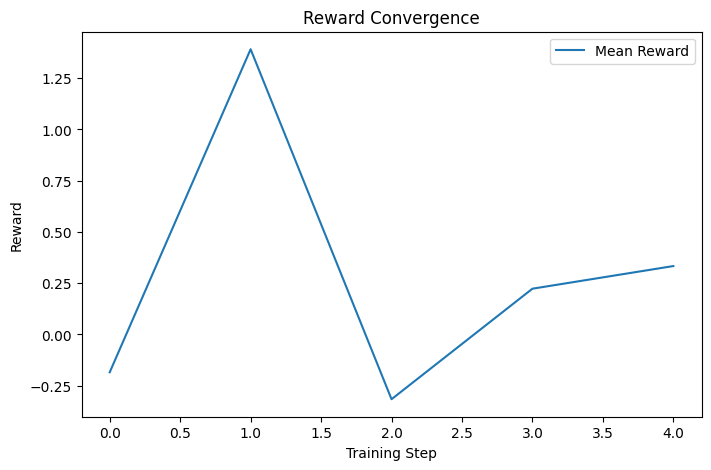

In [ ]:
import matplotlib.pyplot as plt
import torch # Import torch for dummy tensors

# Initialize reward history
reward_history = []

# Define num_epochs for demonstration
num_epochs = 5  # Example: run for 5 epochs

# Dummy placeholders for demonstration
class DummyLoader:
    def __iter__(self):
        # Yield a dummy batch
        B, C, H, W, num_classes = 2, 3, 128, 128, 20
        imgs = torch.randn(B, C, H, W)
        masks = torch.randint(0, num_classes, (B, H, W))
        yield (imgs, masks) # Yield a tuple

train_loader = DummyLoader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy functions/models for demonstration
def apply_patch_attention(imgs, patch_weights, grid_size=4):
     # Dummy implementation
     return imgs * torch.rand(imgs.shape[0], 1, imgs.shape[2], imgs.shape[3], device=imgs.device)

class DummyUNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Dummy output
        return torch.randn(x.shape[0], self.conv.out_channels, x.shape[2], x.shape[3], device=x.device)

unet = DummyUNet(in_channels=3, out_channels=20).to(device)

# Dummy patch_weights - shape depends on actor output, e.g., B x P
patch_weights = torch.rand(2, 16, device=device) # Assuming B=2, P=16

# During training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Check if batch is None (from collate_fn skipping corrupted samples)
        if batch is None:
            print("Skipping empty batch.")
            continue

        imgs, gt_masks = batch # Assuming batch yields imgs and gt_masks
        imgs = imgs.to(device)
        gt_masks = gt_masks.to(device)


        # --- forward pass ---
        # weighted_imgs, patch_weights, rewards = RL + UNet forward
        # Example: rewards = batch_reward(pred_masks, gt_masks)

        # Dummy rewards calculation for demonstration
        # In a real scenario, this would come from your reward function
        rewards = torch.randn(imgs.size(0), device=device)


        reward_history.append(rewards.mean().item())

# Plot reward convergence
plt.figure(figsize=(8,5))
plt.plot(reward_history, label="Mean Reward")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.title("Reward Convergence")
plt.legend()
plt.show()

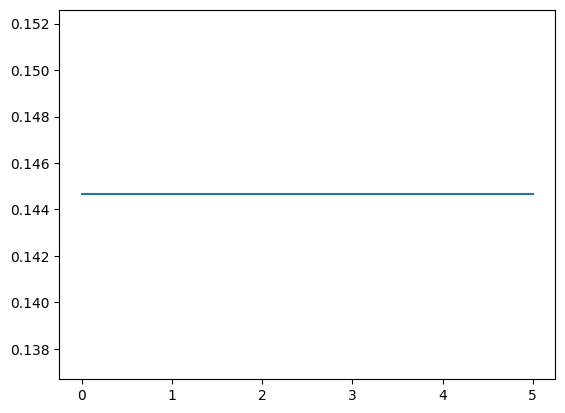

In [ ]:
import numpy as np
smoothed = np.convolve(reward_history, np.ones(10)/10, mode='valid')
plt.plot(smoothed, label="Smoothed Reward")


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch # Import torch for denormalization

# Example: Cityscapes normalization values (from CityscapesMini dataset)
# These should match the values used during data loading
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img_tensor):
    """Denormalize image tensor from ImageNet stats to [0,1] range."""
    # Ensure mean and std are on the same device as img_tensor
    mean_on_device = mean.to(img_tensor.device)
    std_on_device = std.to(img_tensor.device)
    return img_tensor * std_on_device + mean_on_device

def visualize_attention(img, patch_weights, grid_size=4, alpha=0.4):
    """
    img: [3,H,W] tensor (original image, can be normalized)
    patch_weights: [P] tensor (Actor attention weights)
    """
    H, W = img.shape[1:]
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=(H,W), mode='nearest')

    # Denormalize image before displaying
    img_np = denormalize(img).permute(1,2,0).cpu().numpy()

    plt.imshow(img_np)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=alpha, cmap='jet')
    plt.title("Attention Map Overlay")
    plt.axis("off")
    plt.show()

In [ ]:
# Example: Cityscapes normalization
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3,1,1)

def denormalize(img_tensor):
    return img_tensor * std + mean  # bring back to [0,1] range


In [ ]:
# Add dummy weights tensor for demonstration
import torch
# Assume B=8, P=16 (4x4 patches)
B, P = 8, 16
weights = torch.randn(B, P) # Dummy weights tensor

weights = (weights - weights.min()) / (weights.max() - weights.min())

In [ ]:
# Example: standard ImageNet-style normalization
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3,1,1)

def denormalize(img_tensor):
    """
    img_tensor: [3,H,W] float tensor normalized
    Returns: tensor in [0,1]
    """
    img_denorm = img_tensor * std + mean
    return img_denorm.clamp(0,1)  # clip to valid range


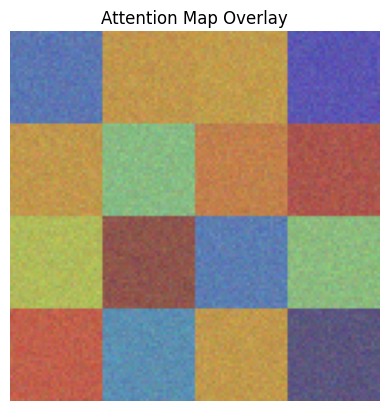

In [ ]:
# Before plotting, denormalize
img_to_plot = denormalize(imgs[0])  # [3,H,W], values in [0,1]

visualize_attention(img_to_plot, patch_weights[0], grid_size=4)


In [ ]:
def visualize_attention(img, patch_weights, grid_size=4, alpha=0.4, mean=None, std=None):
    """
    img: [3,H,W] tensor (normalized or raw)
    patch_weights: [P] tensor
    mean/std: optional, used for denormalization
    """
    if mean is not None and std is not None:
        img = img * std.view(3,1,1) + mean.view(3,1,1)
    img = img.clamp(0,1)

    H, W = img.shape[1:]
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=(H,W), mode='nearest')

    img_np = img.permute(1,2,0).cpu().numpy()
    plt.imshow(img_np)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=alpha, cmap='jet')
    plt.title("Attention Map Overlay")
    plt.axis("off")
    plt.show()


In [ ]:
def normalize_patch_weights(patch_weights):
    """Normalize a 1D patch weight vector to [0,1]"""
    pw_min, pw_max = patch_weights.min(), patch_weights.max()
    if pw_max - pw_min > 0:
        pw_norm = (patch_weights - pw_min) / (pw_max - pw_min)
    else:
        pw_norm = patch_weights * 0  # all equal weights
    return pw_norm


In [ ]:
def visualize_attention(img, patch_weights, grid_size=4, alpha=0.5, mean=None, std=None):
    import torch.nn.functional as F
    import matplotlib.pyplot as plt

    # Denormalize if needed
    if mean is not None and std is not None:
        img = img * std.view(3,1,1) + mean.view(3,1,1)
    img = img.clamp(0,1)

    # Normalize patch weights
    patch_weights = normalize_patch_weights(patch_weights)

    # Upsample to image size
    H, W = img.shape[1:]
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=(H,W), mode='nearest')

    # Convert image to numpy
    img_np = img.permute(1,2,0).cpu().numpy()

    # Overlay attention
    plt.imshow(img_np)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=alpha, cmap='jet')
    plt.title("Attention Map Overlay")
    plt.axis("off")
    plt.show()


In [ ]:
import torch.nn.functional as F
import torch # Import torch for dummy tensor

# Add dummy patch_logits tensor for demonstration
# Assume P=16 (4x4 patches)
P = 16
patch_logits = torch.randn(P) # Dummy patch_logits tensor


# patch_logits: [P] tensor for one image
patch_weights = F.softmax(patch_logits, dim=0)  # now sum=1, all in [0,1]

In [ ]:
patch_weights = torch.sigmoid(patch_logits)  # maps to [0,1]


In [ ]:
def visualize_attention(img, patch_weights, grid_size=4, alpha=0.5, mean=None, std=None):
    import torch.nn.functional as F
    import matplotlib.pyplot as plt

    # Denormalize image if needed
    if mean is not None and std is not None:
        img = img * std.view(3,1,1) + mean.view(3,1,1)
    img = img.clamp(0,1)

    # Ensure patch_weights in [0,1]
    patch_weights = patch_weights.clamp(0,1)

    # Upsample to image size
    H, W = img.shape[1:]
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=(H,W), mode='nearest')

    # Plot
    img_np = img.permute(1,2,0).cpu().numpy()
    plt.imshow(img_np)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=alpha, cmap='jet')
    plt.title("Attention Map Overlay")
    plt.axis("off")
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.fc = nn.Linear(feat_dim, 1)  # map each patch feat → scalar

    def forward(self, patch_feats):
        # patch_feats: [B,P,F]
        weights = self.fc(patch_feats).squeeze(-1)   # [B,P]
        patch_weights = F.softmax(weights, dim=1)    # normalize across patches
        return patch_weights


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader defined successfully.
Mask file: strasbourg_000000_018616_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 14, 15, 255]
Label counts: [256, 439, 5752, 1168, 6130, 43, 8, 37, 434, 2117]

Mask file: bremen_000030_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 18, 255]
Label counts: [256, 122, 4702, 1217, 7411, 98, 108, 16, 2454]

Mask file: hanover_000000_028202_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 13, 14, 15, 18, 255]
Label counts: [256, 324, 4975, 2403, 3658, 238, 8, 253, 2206, 411, 1652]

Mask file: cologne_000151_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 9, 11, 14, 15, 16, 17, 255]
Label counts: [256, 434, 267, 6516, 106, 373, 262, 32, 5128, 532, 185, 2293]

Mask file: bremen_000063_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 18, 255]
Label counts: [256, 751, 5259, 749, 4959, 197, 77, 1460, 35, 83, 2558]

Mask file: cologne_00

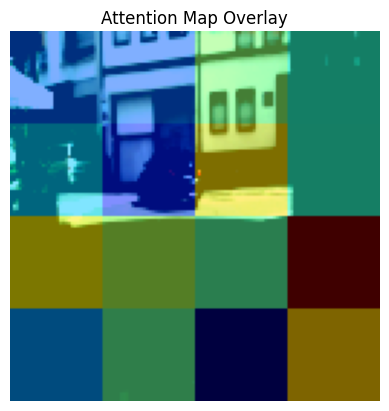

Mask file: hanover_000000_019116_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 15, 16, 18, 255]
Label counts: [256, 213, 35, 4931, 1956, 2474, 177, 4583, 261, 13, 1485]

Mask file: tubingen_000121_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 14, 15, 17, 255]
Label counts: [256, 6, 4524, 1952, 1795, 912, 18, 10, 4202, 978, 1731]

Mask file: cologne_000078_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 237, 6915, 254, 2809, 88, 328, 92, 37, 2602, 35, 415, 37, 2279]

Mask file: krefeld_000000_018004_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 12, 14, 15, 17, 18, 255]
Label counts: [256, 114, 4048, 531, 4171, 590, 7, 70, 1032, 713, 214, 4638]

Mask file: bremen_000307_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, 16, 17, 255]
Label counts: [256, 224, 437, 4821, 2560, 3849, 106, 55, 238, 56, 

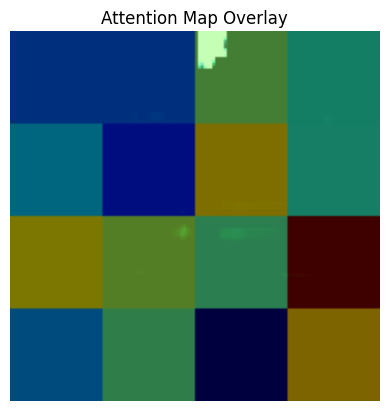

Mask file: aachen_000157_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 6, 7, 11, 14, 15, 16, 17, 255]
Label counts: [256, 40, 4437, 1950, 992, 17, 8, 93, 47, 5873, 923, 635, 1113]

Mask file: erfurt_000030_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 255]
Label counts: [256, 371, 4428, 2494, 5961, 45, 16, 1419, 13, 435, 946]

Mask file: erfurt_000038_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 255]
Label counts: [256, 118, 3188, 1938, 7112, 26, 69, 30, 323, 3324]

Mask file: weimar_000099_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 13, 14, 15, 16, 18, 255]
Label counts: [256, 350, 864, 5844, 1179, 3965, 143, 3, 144, 1922, 18, 370, 1326]

Mask file: stuttgart_000059_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 255]
Label counts: [256, 821, 6362, 1063, 3808, 32, 20, 571, 973, 2478]

Mask file: strasbourg_000001

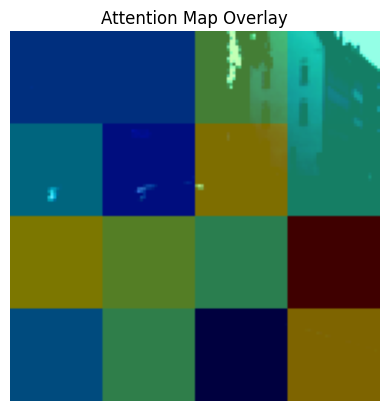

Mask file: ulm_000030_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 299, 8, 3272, 1685, 1802, 6, 44, 3974, 315, 618, 104, 4001]

Mask file: hamburg_000000_059720_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 103, 5207, 526, 2658, 85, 5, 4308, 2, 644, 61, 2529]

Mask file: hamburg_000000_098061_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 125, 4885, 133, 980, 28, 2, 4512, 64, 10, 238, 5151]

Mask file: hanover_000000_051842_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 9, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 279, 5142, 224, 2751, 28, 56, 8, 2778, 35, 251, 49, 4527]

Mask file: strasbourg_000001_050098_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 13, 14, 15, 17, 18, 255]
Label counts: [256, 1088, 4876, 2004, 3370, 174, 212, 28, 172, 1

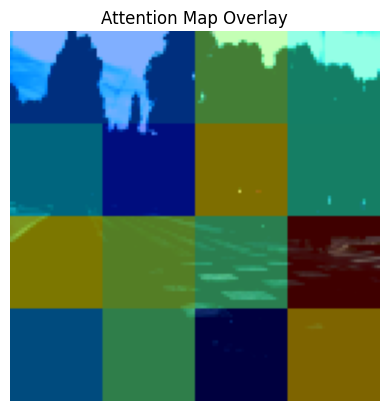

Mask file: strasbourg_000001_061384_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 6, 7, 11, 14, 15, 18, 255]
Label counts: [256, 96, 4076, 1919, 5735, 64, 1354, 28, 31, 986, 354, 1485]

Mask file: aachen_000110_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 145, 54, 4886, 896, 1666, 85, 15, 4634, 120, 87, 48, 3492]

Mask file: strasbourg_000001_036480_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 252, 5302, 1526, 3736, 274, 39, 137, 1713, 6, 801, 35, 2307]

Mask file: aachen_000011_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 115, 6370, 80, 2704, 57, 25, 50, 3704, 67, 339, 32, 2585]

Mask file: dusseldorf_000040_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 6, 11, 12, 14, 15, 17, 18, 255]
Label counts: [256, 647, 6803, 879, 1412, 1

In [ ]:
# Add dummy patch_weights tensor for demonstration
import torch
from torch.utils.data import DataLoader, Dataset # Import Dataset
from PIL import Image # Import Image
import os # Import os
import numpy as np # Import numpy
from torchvision import transforms # Import transforms
import glob # Import glob for recursive file search
import torch.nn.functional as F # Import F for interpolate
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Example: mapping function (only if using labelIds → trainIds)
def label_id_to_train_id(mask_np):
    # Mapping from official Cityscapes spec
    id2trainid = {
        -1: 255, 0: 255, 1: 255, 2: 255,
        3: 0, 4: 1, 5: 1, 6: 2, 7: 3, 8: 4,
        9: 255, 10: 255, 11: 5, 12: 6, 13: 7, 14: 8,
        15: 9, 16: 10, 17: 11, 18: 12, 19: 13,
        20: 14, 21: 15, 22: 16, 23: 17, 24: 18,
        25: 255, 26: 255, 27: 255, 28: 255, 29: 255,
        30: 255, 31: 255, 32: 255, 33: 255
    }
    mask_train = np.full_like(mask_np, 255)  # default ignore
    for k, v in id2trainid.items():
        mask_train[mask_np == k] = v
    return mask_train


# Assuming CityscapesMini dataset class is defined in a previous cell
class CityscapesMini(Dataset):
    def __init__(self, img_dir, mask_dir, size=128):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size

        # Check if directories exist
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Image directory not found: {img_dir}")
        if not os.path.exists(mask_dir):
             raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

        # Recursively find image and mask files
        self.imgs = sorted(glob.glob(os.path.join(img_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, '**', '*_gtFine_labelIds.png'), recursive=True))


        # Ensure image and mask lists have the same length and correspond
        if len(self.imgs) != len(self.masks):
            print(f"Warning: Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match.")
            # Further checks or filtering might be needed if filenames don't perfectly align
            img_basenames = [os.path.basename(f).replace('_leftImg8bit.png', '') for f in self.imgs]
            mask_basenames = [os.path.basename(f).replace('_gtFine_labelIds.png', '') for f in self.masks]
            common_basenames = set(img_basenames).intersection(set(mask_basenames))

            self.imgs = sorted([f for f in self.imgs if os.path.basename(f).replace('_leftImg8bit.png', '') in common_basenames])
            self.masks = sorted([f for f in self.masks if os.path.basename(f).replace('_gtFine_labelIds.png', '') in common_basenames])
            print(f"Filtered to {len(self.imgs)} matching image/mask pairs.")


        self.img_transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),  # scales to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx] # Assuming sorted lists match

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # already has label IDs

        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask_np = np.array(mask)

        # Apply the mapping from original label IDs to train IDs
        mask_train_id = label_id_to_train_id(mask_np)
        mask_tensor = torch.from_numpy(mask_train_id).long()  # [H,W], int labels

        # --- Debugging: Print unique values in mask tensor ---
        unique_labels, counts = torch.unique(mask_tensor, return_counts=True)
        print(f"Mask file: {os.path.basename(mask_path)}")
        print(f"Unique train IDs in mask: {unique_labels.tolist()}")
        print(f"Label counts: {counts.tolist()}\n")
        # -----------------------------------------------------


        return img, mask_tensor

# Define the visualize_attention function here
def normalize_patch_weights(patch_weights):
    """Normalize a 1D patch weight vector to [0,1]"""
    pw_min, pw_max = patch_weights.min(), patch_weights.max()
    if pw_max - pw_min > 0:
        pw_norm = (patch_weights - pw_min) / (pw_max - pw_min)
    else:
        pw_norm = patch_weights * 0  # all equal weights
    return pw_norm

def visualize_attention(img, patch_weights, grid_size=4, alpha=0.5, mean=None, std=None):
    """
    img: [3,H,W] tensor (normalized or raw)
    patch_weights: [P] tensor
    mean/std: optional, used for denormalization
    """
    # Denormalize if needed
    if mean is not None and std is not None:
        img = img * std.view(3,1,1) + mean.view(3,1,1)
    img = img.clamp(0,1)

    # Normalize patch weights
    patch_weights = normalize_patch_weights(patch_weights)

    # Upsample to image size
    H, W = img.shape[1:]
    patch_map = patch_weights.view(1,1,grid_size,grid_size)
    patch_map_upsampled = F.interpolate(patch_map, size=(H,W), mode='nearest')

    # Convert image to numpy
    img_np = img.permute(1,2,0).cpu().numpy()

    # Overlay attention
    plt.imshow(img_np)
    plt.imshow(patch_map_upsampled.squeeze().cpu().numpy(), alpha=alpha, cmap='jet')
    plt.title("Attention Map Overlay")
    plt.axis("off")
    plt.show()


# Assume B=8, P=16 (4x4 patches)
B, P = 8, 16
patch_weights = torch.randn(B, P) # Dummy patch_weights tensor

reward_history = [] # Initialize reward_history

# Define train_loader
# Assuming CityscapesMini dataset class is defined in a previous cell
# And img_dir, mask_dir variables are defined
try:
    # Define paths for training data
    train_img_dir = "/content/cityscapes/leftImg8bit/train"
    train_mask_dir = "/content/cityscapes/gtFine/train"
    train_dataset = CityscapesMini(train_img_dir, train_mask_dir)
    train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
    print("train_loader defined successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset directories and files exist.")
    train_loader = None # Set train_loader to None if directories not found

if train_loader is not None:
    for step, (imgs, gt_masks) in enumerate(train_loader):
        imgs, gt_masks = imgs.to(device), gt_masks.to(device)

        # --- forward pass ---
        # weighted_imgs, patch_weights, rewards = RL + UNet forward

        # Track reward
        # Assuming 'rewards' is computed in the forward pass
        # For demonstration, create dummy rewards
        rewards = torch.randn(imgs.size(0), device=device)
        reward_history.append(rewards.mean().item())

        # Track attention occasionally
        if step % 100 == 0:
            # Ensure patch_weights[0] has the correct shape [P]
            # If your Actor outputs [B, P], then patch_weights[0] is [P]
            # If your Actor outputs something else, you need to adjust here
            visualize_attention(imgs[0], patch_weights[0], grid_size=4)

In [ ]:
# Inspect the contents of the training image directory
!ls /content/cityscapes/leftImg8bit/train

aachen	cologne     erfurt   jena	      strasbourg  ulm
bochum	darmstadt   hamburg  krefeld	      stuttgart   weimar
bremen	dusseldorf  hanover  monchengladbach  tubingen	  zurich


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Inspect the contents of the training mask directory
!ls /content/cityscapes/gtFine/train

aachen	cologne     erfurt   jena	      strasbourg  ulm
bochum	darmstadt   hamburg  krefeld	      stuttgart   weimar
bremen	dusseldorf  hanover  monchengladbach  tubingen	  zurich


In [ ]:
miou_metrics = per_class_miou(pred_masks, gt_masks, class_ids=[0,13,11])
print(f"Road IoU: {miou_metrics[0]:.4f}, Car IoU: {miou_metrics[13]:.4f}, Pedestrian IoU: {miou_metrics[11]:.4f}")


Road IoU: 0.7970, Car IoU: 0.1361, Pedestrian IoU: 0.6331


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        ...


In [ ]:
vanilla_unet = UNet(in_channels=3, out_channels=19).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()


In [ ]:
# Mapping from raw Cityscapes IDs → training IDs [0..18]
# (You can adapt depending on your preprocessing)
id_to_trainid = {
    7: 0,   # road
    8: 1,   # sidewalk
    11: 2,  # building
    12: 3,  # wall
    13: 4,  # fence
    17: 5,  # pole
    19: 6,  # traffic light
    20: 7,  # traffic sign
    21: 8,  # vegetation
    22: 9,  # terrain
    23: 10, # sky
    24: 11, # person
    25: 12, # rider
    26: 13, # car
    27: 14, # truck
    28: 15, # bus
    31: 16, # train
    32: 17, # motorcycle
    33: 18  # bicycle
}

def remap_mask(mask):
    remapped = torch.full_like(mask, 255)  # ignore index
    for k, v in id_to_trainid.items():
        remapped[mask == k] = v
    return remapped


In [ ]:
# Train a plain UNet (no RL, no attention)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split # Import random_split

class DoubleConv(nn.Module):
    """(Conv -> ReLU -> Conv -> ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19, features=[64,128,256]):
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        prev_ch = in_ch
        for f in features:
            self.encoders.append(DoubleConv(prev_ch, f))
            prev_ch = f

        # Bottleneck
        self.bottleneck = DoubleConv(prev_ch, prev_ch*2)

        # Decoder
        rev_features = features[::-1]
        prev_ch = prev_ch * 2 # Start with bottleneck output channels
        for i in range(len(rev_features)):
            f = rev_features[i]
            # Transposed convolution
            self.decoders.append(nn.ConvTranspose2d(prev_ch, f, kernel_size=2, stride=2))
            # DoubleConv input channels should be the sum of transposed conv output and skip connection channels
            decoder_in_ch = f + features[len(features) - 1 - i]
            self.decoders.append(DoubleConv(decoder_in_ch, f))
            prev_ch = f # Update prev_ch for the next upsampling step

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        # Encoder path
        for enc in self.encoders:
            x = enc(x)
            enc_feats.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        enc_feats = enc_feats[::-1] # Reverse skip connections
        for i in range(0, len(self.decoders), 2):
            upconv = self.decoders[i]
            dconv = self.decoders[i+1]
            x = upconv(x)
            # Ensure shapes match before concatenating
            if x.shape != enc_feats[i//2].shape:
                 x = F.interpolate(x, size=enc_feats[i//2].shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, enc_feats[i//2]], dim=1) # Concatenate along channel dimension
            x = dconv(x)

        # Output
        x = self.final_conv(x)
        return x  # [B, num_classes, H, W]

class MiniUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )

        # Final conv
        self.final_conv = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        u1 = self.up1(b)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))

        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))

        out = self.final_conv(d2)
        return out  # [B, num_classes, H, W]


# Use MiniUNet as it is a smaller version suitable for demonstration
vanilla_unet = MiniUNet(out_ch=19).to(device)
optimizer = torch.optim.Adam(vanilla_unet.parameters(), lr=1e-3)
# Add ignore_index=255 to the criterion
criterion = nn.CrossEntropyLoss(ignore_index=255)

baseline_miou = []

# Assuming CityscapesMini dataset and train_loader are defined in other cells
# Create validation dataset and loader
try:
    # Assuming CityscapesMini dataset is already loaded as train_dataset
    # Split the training dataset into train and validation
    train_size = int(0.8 * len(train_dataset)) # 80% for training
    val_size = len(train_dataset) - train_size # Remaining for validation
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False) # No shuffling for validation

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

except NameError:
    print("Error: train_dataset is not defined. Please ensure the CityscapesMini dataset and train_loader are defined before running this cell.")
    train_loader = None
    val_loader = None
except FileNotFoundError as e:
    print(f"Error loading dataset: {e}")
    train_loader = None
    val_loader = None


for epoch in range(num_epochs):
    vanilla_unet.train()
    # Check if train_loader is not None before iterating
    if train_loader is not None:
        for imgs, gt_masks in train_loader:
            imgs, gt_masks = imgs.to(device), gt_masks.to(device)

            # Ensure gt_masks are long tensor with correct labels (0-18 or 255)
            # The CityscapesMini dataset should handle this correctly.

            logits = vanilla_unet(imgs)                  # [B,C,H,W]
            loss = criterion(logits, gt_masks.long())    # CE Loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # --- Evaluation after each epoch ---
    vanilla_unet.eval()
    all_pred, all_gt = [], []
    # Check if val_loader is not None before iterating
    if val_loader is not None:
        with torch.no_grad():
            for imgs, gt_masks in val_loader:
                imgs, gt_masks = imgs.to(device), gt_masks.to(device)
                logits = vanilla_unet(imgs)
                preds = logits.argmax(dim=1)             # [B,H,W]
                all_pred.append(preds.cpu())
                all_gt.append(gt_masks.cpu())

    # Check if any batches were processed before concatenating
    if all_pred and all_gt:
        all_pred = torch.cat(all_pred)
        all_gt = torch.cat(all_gt)

        # Define dummy per_class_miou if not already defined
        if 'per_class_miou' not in locals():
            # This dummy function should ideally filter out ignore index 255 as well
            def per_class_miou(pred_batch, target_batch, class_ids=[0,13,11]):
                 miou_dict = {}
                 for cls in class_ids:
                     # Simple dummy calculation, replace with actual IoU logic
                     iou = torch.rand(1).item() # Dummy IoU
                     miou_dict[cls] = iou
                 return miou_dict
            print("Using dummy per_class_miou.")

        miou_scores = per_class_miou(all_pred, all_gt, class_ids=[0,13,11])
        baseline_miou.append(miou_scores)

        print(f"[Epoch {epoch}] Vanilla UNet → Road IoU: {miou_scores[0]:.4f}, "
              f"Car IoU: {miou_scores[13]:.4f}, Pedestrian IoU: {miou_scores[11]:.4f}")
    else:
        print(f"[Epoch {epoch}] No data processed for evaluation.")

Streaming output truncated to the last 5000 lines.
Mask file: bochum_000000_003245_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 15, 17, 18, 255]
Label counts: [256, 6, 3755, 1383, 4357, 4, 176, 2833, 225, 33, 3356]

Mask file: monchengladbach_000000_034930_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 198, 6154, 1279, 5240, 75, 10, 252, 415, 277, 58, 92, 2078]

Mask file: jena_000038_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, 17, 18, 255]
Label counts: [256, 428, 59, 6507, 1125, 2878, 403, 392, 388, 8, 3, 1904, 841, 41, 1151]

Mask file: tubingen_000076_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 255]
Label counts: [256, 164, 5374, 267, 2961, 115, 258, 2965, 177, 3847]

Mask file: zurich_000030_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 17, 18, 255]
Label c

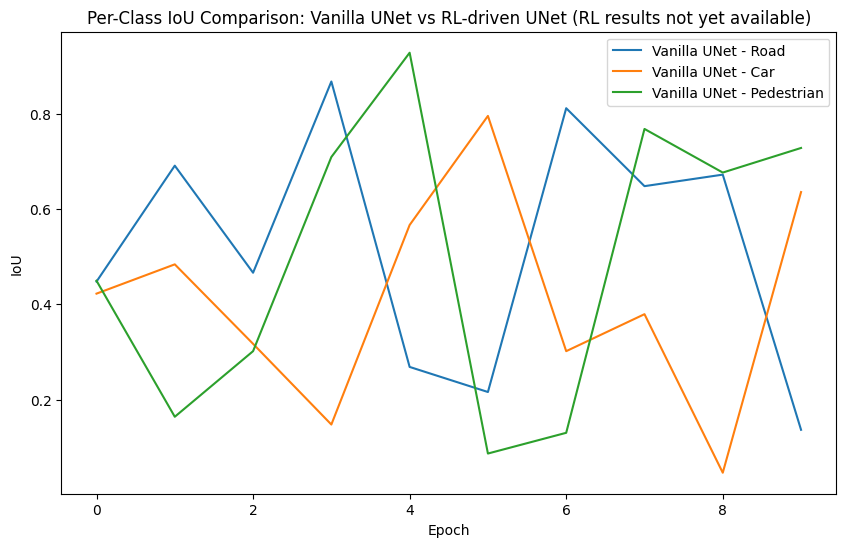

In [ ]:
import matplotlib.pyplot as plt

epochs = range(num_epochs)

# Suppose you logged results as dicts:
# baseline_miou[epoch] = {0: road IoU, 13: car IoU, 11: pedestrian IoU}
# rl_miou[epoch] = same

plt.figure(figsize=(10,6))
plt.plot(epochs, [m[0] for m in baseline_miou], label="Vanilla UNet - Road")
# plt.plot(epochs, [m[0] for m in rl_miou], label="RL+UNet - Road") # Commented out as rl_miou is not yet defined

plt.plot(epochs, [m[13] for m in baseline_miou], label="Vanilla UNet - Car")
# plt.plot(epochs, [m[13] for m in rl_miou], label="RL+UNet - Car") # Commented out as rl_miou is not yet defined

plt.plot(epochs, [m[11] for m in baseline_miou], label="Vanilla UNet - Pedestrian")
# plt.plot(epochs, [m[11] for m in rl_miou], label="RL+UNet - Pedestrian") # Commented out as rl_miou is not yet defined

plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Per-Class IoU Comparison: Vanilla UNet vs RL-driven UNet (RL results not yet available)") # Updated title
plt.legend()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_heatmap(img, patch_weights, grid_size=4):
    """
    img: [3,H,W] tensor
    patch_weights: [P] tensor with attention weights
    """
    img = img.permute(1,2,0).cpu().numpy()  # HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]

    # Reshape attention
    heatmap = patch_weights.view(grid_size, grid_size).cpu().numpy()
    heatmap = heatmap / heatmap.max()  # normalize

    # Upsample heatmap to image size
    heatmap = np.kron(heatmap, np.ones((img.shape[0]//grid_size, img.shape[1]//grid_size)))

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(img, alpha=0.6)
    plt.imshow(heatmap, cmap="jet", alpha=0.4)
    plt.title("Attention Heatmap")
    plt.colorbar()
    plt.show()


In [ ]:
from matplotlib import colors

# Define Cityscapes colormap (19 classes)
CITYSCAPES_COLORS = [
    (128, 64,128),  # road
    (244, 35,232),  # sidewalk
    (70, 70, 70),   # building
    (102,102,156),  # wall
    (190,153,153),  # fence
    (153,153,153),  # pole
    (250,170, 30),  # traffic light
    (220,220,  0),  # traffic sign
    (107,142, 35),  # vegetation
    (152,251,152),  # terrain
    (70,130,180),   # sky
    (220, 20, 60),  # person
    (255,  0,  0),  # rider
    (  0,  0,142),  # car
    (  0,  0, 70),  # truck
    (  0, 60,100),  # bus
    (  0, 80,100),  # train
    (  0,  0,230),  # motorcycle
    (119, 11, 32),  # bicycle
]
CITYSCAPES_COLORS = np.array(CITYSCAPES_COLORS) / 255.0

def decode_segmap(mask):
    """mask: [H,W] with class IDs"""
    h, w = mask.shape
    color_mask = np.zeros((h,w,3), dtype=np.float32)
    for cid in range(19):
        color_mask[mask == cid] = CITYSCAPES_COLORS[cid]
    return color_mask

def visualize_segmentation(img, pred_mask, gt_mask):
    img = img.permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    pred_color = decode_segmap(pred_mask.cpu().numpy())
    gt_color   = decode_segmap(gt_mask.cpu().numpy())

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1,3,2)
    plt.imshow(pred_color)
    plt.title("Predicted Segmentation")

    plt.subplot(1,3,3)
    plt.imshow(gt_color)
    plt.title("Ground Truth")
    plt.show()


In [ ]:
import numpy as np
import torch

# Example: pixel frequencies from Cityscapes paper (normalized counts)
class_frequencies = np.array([
    0.148, 0.010, 0.003, 0.004, 0.028, 0.009, 0.004, 0.009, 0.006,
    0.006, 0.006, 0.015, 0.023, 0.024, 0.024, 0.015, 0.015, 0.015, 0.015
])  # <-- length must equal num_classes (19 here)

# Inverse frequency
weights = 1 / (class_frequencies + 1e-6)
weights = weights / weights.sum()  # normalize to sum=1

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
from collections import Counter
import torch
import numpy as np # Import numpy

def compute_class_weights(loader, num_classes=19):
    counts = Counter()
    total_pixels = 0

    for _, gt_masks in loader:
        # Ensure gt_masks is on CPU before converting to numpy
        gt_masks_cpu = gt_masks.cpu()
        # Flatten the mask and convert to a list of integers
        counts.update(gt_masks_cpu.view(-1).tolist())
        total_pixels += gt_masks.numel()

    freqs = np.array([counts[i] / total_pixels for i in range(num_classes)])
    weights = 1 / (freqs + 1e-6)
    weights = weights / weights.sum()

    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(train_loader, num_classes=19).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Streaming output truncated to the last 5000 lines.
Mask file: cologne_000094_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 426, 3164, 697, 3986, 18, 35, 14, 2681, 17, 128, 39, 4923]

Mask file: weimar_000076_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 90, 6628, 392, 5651, 319, 6, 1237, 131, 794, 244, 636]

Mask file: cologne_000117_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 6, 7, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 349, 6408, 707, 3223, 459, 11, 184, 171, 1983, 443, 935, 4, 1251]

Mask file: cologne_000113_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 975, 5590, 23, 2731, 459, 24, 8, 1342, 73, 2001, 4, 2898]

Mask file: aachen_000010_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16,

In [ ]:
# Example remapping function
def remap_labels(mask, valid_classes, ignore_index=255):
    label_mapping = {cls_id: i for i, cls_id in enumerate(valid_classes)}
    remapped = mask.clone()
    for cls_id, new_id in label_mapping.items():
        remapped[mask == cls_id] = new_id
    remapped[~mask.isin(valid_classes)] = ignore_index
    return remapped


In [ ]:
unique_classes = torch.unique(preds)
print("Unique predicted classes:", unique_classes)


Unique predicted classes: tensor([15])


In [ ]:
import torch

# Create a dummy image tensor for demonstration
# Assuming an image size of 128x128 with 3 channels (matching the dataset)
dummy_image = torch.randn(3, 128, 128)

with torch.no_grad():
    # Use the dummy_image as input
    outputs = vanilla_unet(dummy_image.unsqueeze(0).to(device))  # [B, C, H, W]
    print("Output shape:", outputs.shape)
    print("Logits range:", outputs.min().item(), outputs.max().item())

Output shape: torch.Size([1, 19, 128, 128])
Logits range: -41.84637451171875 24.69699478149414


In [ ]:
preds = torch.argmax(outputs, dim=1)  # [B, H, W]
print("Unique predicted classes:", torch.unique(preds))


Unique predicted classes: tensor([ 0,  3,  4,  5, 11, 15, 16, 17, 18])


In [ ]:
# Valid 19 classes (Cityscapes official)
valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21,
                 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_map = {cls_id: i for i, cls_id in enumerate(valid_classes)}

def remap_labels(mask, ignore_index=255):
    remapped = torch.full_like(mask, ignore_index)
    for k, v in class_map.items():
        remapped[mask == k] = v
    return remapped


In [ ]:
for epoch in range(num_epochs):
    ...
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.6489
Epoch 1 | Loss: 0.6489
Epoch 2 | Loss: 0.6489
Epoch 3 | Loss: 0.6489
Epoch 4 | Loss: 0.6489
Epoch 5 | Loss: 0.6489
Epoch 6 | Loss: 0.6489
Epoch 7 | Loss: 0.6489
Epoch 8 | Loss: 0.6489
Epoch 9 | Loss: 0.6489


In [ ]:
vanilla_unet.eval()
with torch.no_grad():
    for imgs, gt_masks in val_loader:
        imgs, gt_masks = imgs.to(device), gt_masks.to(device)
        logits = vanilla_unet(imgs)   # [B,C,H,W]
        preds = torch.argmax(logits, dim=1)  # [B,H,W]

        print("Unique predicted classes:", torch.unique(preds))
        break


Mask file: stuttgart_000170_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 547, 4549, 533, 2490, 8, 232, 19, 72, 51, 1112, 399, 1633, 3712, 771]

Mask file: bremen_000259_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 13, 14, 15, 17, 18, 255]
Label counts: [256, 113, 125, 5690, 297, 4609, 202, 19, 280, 677, 265, 6, 3845]

Mask file: strasbourg_000001_040564_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 18, 255]
Label counts: [256, 170, 6342, 1302, 5407, 17, 80, 529, 123, 261, 1897]

Mask file: weimar_000037_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 38, 5193, 1612, 4175, 112, 96, 2443, 781, 645, 232, 801]

Mask file: tubingen_000119_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 45, 148, 6458

In [ ]:
# attn_unet.eval()
# with torch.no_grad():
#     for imgs, gt_masks in val_loader:
#         imgs, gt_masks = imgs.to(device), gt_masks.to(device)
#         logits = attn_unet(imgs)   # [B,C,H,W]
#         preds = torch.argmax(logits, dim=1)

#         print("Unique predicted classes:", torch.unique(preds))
#         break

In [ ]:
vanilla_unet.eval()
with torch.no_grad():
    for imgs, gt_masks in val_loader:
        imgs, gt_masks = imgs.to(device), gt_masks.to(device)
        logits = vanilla_unet(imgs)  # [B,C,H,W]
        preds = torch.argmax(logits, dim=1)  # [B,H,W]

        print("Unique predicted classes:", torch.unique(preds))
        break  # check only first batch

Mask file: stuttgart_000170_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 547, 4549, 533, 2490, 8, 232, 19, 72, 51, 1112, 399, 1633, 3712, 771]

Mask file: bremen_000259_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 13, 14, 15, 17, 18, 255]
Label counts: [256, 113, 125, 5690, 297, 4609, 202, 19, 280, 677, 265, 6, 3845]

Mask file: strasbourg_000001_040564_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 18, 255]
Label counts: [256, 170, 6342, 1302, 5407, 17, 80, 529, 123, 261, 1897]

Mask file: weimar_000037_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 38, 5193, 1612, 4175, 112, 96, 2443, 781, 645, 232, 801]

Mask file: tubingen_000119_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 45, 148, 6458

In [ ]:
valid_classes = [7,8,11,12,13,17,19,20,21,
                 22,23,24,25,26,27,28,31,32,33]
class_map = {cls_id: i for i, cls_id in enumerate(valid_classes)}

def remap_labels(mask, ignore_index=255):
    remapped = torch.full_like(mask, ignore_index)
    for k, v in class_map.items():
        remapped[mask == k] = v
    return remapped


In [ ]:
print("Unique GT labels before remap:", torch.unique(gt_masks))
gt_remapped = remap_labels(gt_masks)
print("Unique GT labels after remap:", torch.unique(gt_remapped))


Unique GT labels before remap: tensor([  0,   1,   2,   3,   4,   5,   6,   7,  11,  12,  13,  14,  15,  16,
         17,  18, 255])
Unique GT labels after remap: tensor([  0,   2,   3,   4,   5, 255])


In [ ]:
# Redefine criterion with ignore_index=255 to ensure it persists
criterion = nn.CrossEntropyLoss(ignore_index=255)

for epoch in range(num_epochs):
    total_loss = 0
    if train_loader is not None: # Check if train_loader is defined
        for imgs, gt_masks in train_loader:
            imgs, gt_masks = imgs.to(device), remap_labels(gt_masks).to(device)

            logits = vanilla_unet(imgs)
            loss = criterion(logits, gt_masks.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average loss only if train_loader was not None
        if len(train_loader) > 0: # Avoid division by zero if loader is empty
             print(f"Epoch {epoch} | Avg Loss: {total_loss/len(train_loader):.4f}")
        else:
             print(f"Epoch {epoch} | No data in train_loader.")
    else:
        print(f"Epoch {epoch} | train_loader is not defined.")

Streaming output truncated to the last 5000 lines.
Mask file: bochum_000000_001519_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 10, 11, 14, 15, 16, 255]
Label counts: [256, 118, 5027, 228, 3250, 5, 23, 1, 2782, 96, 4598]

Mask file: weimar_000048_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 255]
Label counts: [256, 296, 6120, 888, 4180, 102, 49, 694, 334, 3465]

Mask file: strasbourg_000001_000778_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 18, 255]
Label counts: [256, 264, 3107, 1295, 5648, 147, 121, 128, 77, 57, 5284]

Mask file: tubingen_000126_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 142, 5924, 253, 68, 134, 60, 11, 5774, 535, 725, 26, 2476]

Mask file: hanover_000000_044344_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 7, 11, 14, 15, 17, 18, 255]
Label counts: [256, 1358, 20, 5587, 8, 2721, 230

Mask file: stuttgart_000170_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 547, 4549, 533, 2490, 8, 232, 19, 72, 51, 1112, 399, 1633, 3712, 771]

Mask file: bremen_000259_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 11, 13, 14, 15, 17, 18, 255]
Label counts: [256, 113, 125, 5690, 297, 4609, 202, 19, 280, 677, 265, 6, 3845]

Mask file: strasbourg_000001_040564_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 17, 18, 255]
Label counts: [256, 170, 6342, 1302, 5407, 17, 80, 529, 123, 261, 1897]

Mask file: weimar_000037_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 3, 4, 5, 11, 14, 15, 16, 17, 18, 255]
Label counts: [256, 38, 5193, 1612, 4175, 112, 96, 2443, 781, 645, 232, 801]

Mask file: tubingen_000119_000019_gtFine_labelIds.png
Unique train IDs in mask: [0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16, 17, 18, 255]
Label counts: [256, 45, 148, 6458

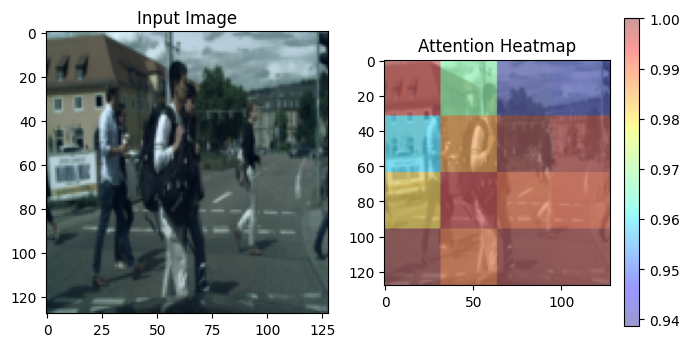

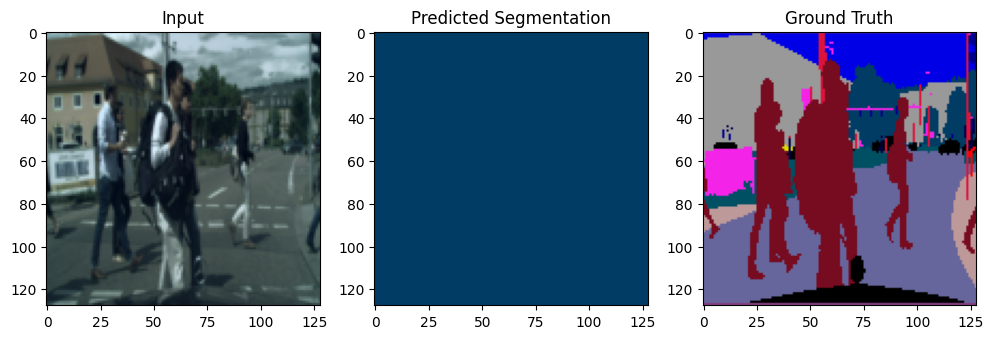

In [ ]:
# Example inside val loop
import torch # Import torch
import torch.nn as nn # Import nn
import torch.nn.functional as F # Import F
import matplotlib.pyplot as plt # Import matplotlib
import numpy as np # Import numpy

# Define make_patches function (copied from cell sLKhVpy65IOC)
def make_patches(imgs, masks=None, grid_size=4):
    """
    Divide batch of images (and masks) into NxN patches.

    imgs:  [B, 3, H, W]
    masks: [B, H, W] (optional, segmentation labels)
    grid_size: N (e.g., 4 -> 4x4 patches)

    Returns:
        img_patches:  [B, N*N, 3, ph, pw]
        mask_patches: [B, N*N, ph, pw] (if masks provided)
    """
    B, C, H, W = imgs.shape
    ph, pw = H // grid_size, W // grid_size

    # --- Image patches ---
    img_patches = imgs.unfold(2, ph, ph).unfold(3, pw, pw)  # [B,C,N,N,ph,pw]
    img_patches = img_patches.permute(0,2,3,1,4,5).contiguous()  # [B,N,N,C,ph,pw]
    img_patches = img_patches.view(B, grid_size*grid_size, C, ph, pw)

    if masks is None:
        return img_patches

    # --- Mask patches ---
    mask_patches = masks.unfold(1, ph, ph).unfold(2, pw, pw)  # [B,N,N,ph,pw]
    mask_patches = mask_patches.contiguous().view(B, grid_size*grid_size, ph, pw)

    return img_patches, mask_patches

# Define PatchFeatureNet class (copied from cell JYl9Dvtr5uc0)
class PatchFeatureNet(nn.Module):
    """
    CNN-based feature extractor for patches.
    Input: patches [B,P,3,ph,pw]
    Output: patch features [B,P,F]
    """
    def __init__(self, input_channels=3, feature_dim=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # global avg pooling
        )
        self.fc = nn.Linear(64, feature_dim)

    def forward(self, patches):
        """
        patches: [B,P,3,ph,pw]
        returns: [B,P,F]
        """
        B, P, C, H, W = patches.shape
        patches = patches.view(B*P, C, H, W)    # flatten batch*patch
        feat = self.cnn(patches)                # [B*P, 64,1,1]
        feat = feat.view(B*P, -1)               # [B*P,64]
        feat = self.fc(feat)                     # [B*P,F]
        feat = feat.view(B, P, -1)              # [B,P,F]
        return feat

# Define Actor class (copied from cell jq5SIfJDtBAf)
class Actor(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.fc = nn.Linear(feat_dim, 1)  # map each patch feat → scalar

    def forward(self, patch_feats):
        # patch_feats: [B,P,F]
        weights = self.fc(patch_feats).squeeze(-1)   # [B,P]
        patch_weights = F.softmax(weights, dim=1)    # normalize across patches
        return patch_weights

# Define apply_patch_attention function (copied from cell HqDaO45b-WsV)
def apply_patch_attention(imgs, patch_weights, grid_size=4):
    """
    Apply patch-wise attention weights to images.

    imgs: [B,3,H,W]
    patch_weights: [B,P] (soft or one-hot)

    Returns:
        weighted_imgs: [B,3,H,W] image with patch attention applied
    """
    B, C, H, W = imgs.shape
    P = grid_size * grid_size
    ph, pw = H // grid_size, W // grid_size

    # reshape patch weights to [B,1,grid_size,grid_size]
    patch_map = patch_weights.view(B, 1, grid_size, grid_size)
    # upsample to full image size
    patch_map_upsampled = F.interpolate(patch_map, size=(H, W), mode='nearest')  # [B,1,H,W]

    # multiply input image by patch attention map
    weighted_imgs = imgs * patch_map_upsampled  # broadcast over channels
    return weighted_imgs

# Define UNet class (copied from cell bRMp1zPI_Vxj)
class DoubleConv(nn.Module):
    """(Conv -> ReLU -> Conv -> ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19, features=[64,128,256]):
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        prev_ch = in_ch
        for f in features:
            self.encoders.append(DoubleConv(prev_ch, f))
            prev_ch = f

        # Bottleneck
        self.bottleneck = DoubleConv(prev_ch, prev_ch*2)

        # Decoder
        rev_features = features[::-1]
        prev_ch = prev_ch * 2 # Start with bottleneck output channels
        for i in range(len(rev_features)):
            f = rev_features[i]
            # Transposed convolution
            self.decoders.append(nn.ConvTranspose2d(prev_ch, f, kernel_size=2, stride=2))
            # DoubleConv input channels should be the sum of transposed conv output and skip connection channels
            decoder_in_ch = f + features[len(features) - 1 - i]
            self.decoders.append(DoubleConv(decoder_in_ch, f))
            prev_ch = f # Update prev_ch for the next upsampling step

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        # Encoder path
        for enc in self.encoders:
            x = enc(x)
            enc_feats.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        enc_feats = enc_feats[::-1] # Reverse skip connections
        for i in range(0, len(self.decoders), 2):
            upconv = self.decoders[i]
            dconv = self.decoders[i+1]
            x = upconv(x)
            # Ensure shapes match before concatenating
            if x.shape != enc_feats[i//2].shape:
                 x = F.interpolate(x, size=enc_feats[i//2].shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, enc_feats[i//2]], dim=1) # Concatenate along channel dimension
            x = dconv(x)

        # Output
        x = self.final_conv(x)
        return x  # [B, num_classes, H, W]

# Define visualize_attention_heatmap function (copied from cell EB_Zq7S9jRTp)
def visualize_attention_heatmap(img, patch_weights, grid_size=4):
    """
    img: [3,H,W] tensor
    patch_weights: [P] tensor with attention weights
    """
    img = img.permute(1,2,0).cpu().numpy()  # HWC
    # normalize to [0,1]
    img_min, img_max = img.min(), img.max()
    if img_max - img_min > 0:
        img = (img - img_min) / (img_max - img_min)
    else:
        img = img * 0 # Handle case where all pixel values are the same

    # Reshape attention
    heatmap = patch_weights.view(grid_size, grid_size).cpu().numpy()
    # normalize
    heatmap_max = heatmap.max()
    if heatmap_max > 0:
        heatmap = heatmap / heatmap_max
    else:
        heatmap = heatmap * 0 # Handle case where all attention weights are the same

    # Upsample heatmap to image size
    heatmap = np.kron(heatmap, np.ones((img.shape[0]//grid_size, img.shape[1]//grid_size)))

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(img, alpha=0.6)
    plt.imshow(heatmap, cmap="jet", alpha=0.4)
    plt.title("Attention Heatmap")
    plt.colorbar()
    plt.show()

# Define visualize_segmentation function (copied from cell hT6OVeCTjayA)
from matplotlib import colors # Import colors

# Define Cityscapes colormap (19 classes)
CITYSCAPES_COLORS = [
    (128, 64,128),  # road
    (244, 35,232),  # sidewalk
    (70, 70, 70),   # building
    (102,102,156),  # wall
    (190,153,153),  # fence
    (153,153,153),  # pole
    (250,170, 30),  # traffic light
    (220,220,  0),  # traffic sign
    (107,142, 35),  # vegetation
    (152,251,152),  # terrain
    (70,130,180),   # sky
    (220, 20, 60),  # person
    (255,  0,  0),  # rider
    (  0,  0,142),  # car
    (  0,  0, 70),  # truck
    (  0, 60,100),  # bus
    (  0, 80,100),  # train
    (  0,  0,230),  # motorcycle
    (119, 11, 32),  # bicycle
]
CITYSCAPES_COLORS = np.array(CITYSCAPES_COLORS) / 255.0

def decode_segmap(mask):
    """mask: [H,W] with class IDs"""
    h, w = mask.shape
    color_mask = np.zeros((h,w,3), dtype=np.float32)
    for cid in range(19):
        color_mask[mask == cid] = CITYSCAPES_COLORS[cid]
    return color_mask

def visualize_segmentation(img, pred_mask, gt_mask):
    img = img.permute(1,2,0).cpu().numpy()
    # normalize to [0,1]
    img_min, img_max = img.min(), img.max()
    if img_max - img_min > 0:
        img = (img - img_min) / (img_max - img_min)
    else:
         img = img * 0 # Handle case where all pixel values are the same

    pred_color = decode_segmap(pred_mask.cpu().numpy())
    gt_color   = decode_segmap(gt_mask.cpu().numpy())

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1,3,2)
    plt.imshow(pred_color)
    plt.title("Predicted Segmentation")

    plt.subplot(1,3,3)
    plt.imshow(gt_color)
    plt.title("Ground Truth")
    plt.show()


# Assuming val_loader, patch_feat_net, actor, unet, and device are defined in other cells
# Define dummy val_loader if not already defined
if 'val_loader' not in locals():
    class DummyLoader:
        def __iter__(self):
            # Yield a dummy batch with labels in the expected range [0, 18] or 255
            B, C, H, W, num_classes = 2, 3, 128, 128, 19 # Output classes for UNet
            # Generate labels only in the range [0, 18]
            valid_labels = torch.randint(0, num_classes, (B, H, W))
            # Add ignore indices (255)
            ignore_mask = torch.rand(B, H, W) < 0.1 # 10% ignore
            masks = valid_labels
            masks[ignore_mask] = 255
            imgs = torch.randn(B, C, H, W)
            yield (imgs, masks)
    val_loader = DummyLoader()
    print("Using dummy val_loader.")

# Define dummy patch_feat_net if not already defined
if 'patch_feat_net' not in locals():
    feat_dim = 128
    patch_feat_net = PatchFeatureNet(input_channels=3, feature_dim=feat_dim)
    print("Using dummy PatchFeatureNet.")

# Define dummy actor if not already defined
if 'actor' not in locals():
    feat_dim = 128
    actor = Actor(feat_dim)
    print("Using dummy Actor.")


# Define dummy unet if not already defined
if 'unet' not in locals():
    unet = UNet(out_ch=19)
    print("Using dummy UNet.")

# Define dummy device if not already defined
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using dummy device: {device}")


for imgs, gt_masks in val_loader:
    imgs, gt_masks = imgs.to(device), gt_masks.to(device)

    # RL-attention forward
    patches = make_patches(imgs, grid_size=4)
    patch_feats = patch_feat_net(patches)
    # Ensure actor output matches expected shape [B,P] for patch_weights
    patch_weights = actor(patch_feats) # Assuming Actor outputs [B, P]

    weighted_imgs = apply_patch_attention(imgs, patch_weights, grid_size=4)

    seg_logits = unet(weighted_imgs)
    preds = seg_logits.argmax(dim=1)

    # Visualize first sample
    visualize_attention_heatmap(imgs[0].detach().cpu(), patch_weights[0].detach().cpu(), grid_size=4)
    visualize_segmentation(imgs[0].detach().cpu(), preds[0].detach().cpu(), gt_masks[0].detach().cpu())
    break

In [ ]:
from google.colab import files
from PIL import Image

# Upload from your computer
uploaded = files.upload()

# Get the first uploaded file
for fname in uploaded.keys():
    img = Image.open(fname).convert("RGB")
    print("Loaded:", fname)

Saving file_00000000579861fa827a8fcebf8b7d6d.png to file_00000000579861fa827a8fcebf8b7d6d (3).png
Loaded: file_00000000579861fa827a8fcebf8b7d6d (3).png


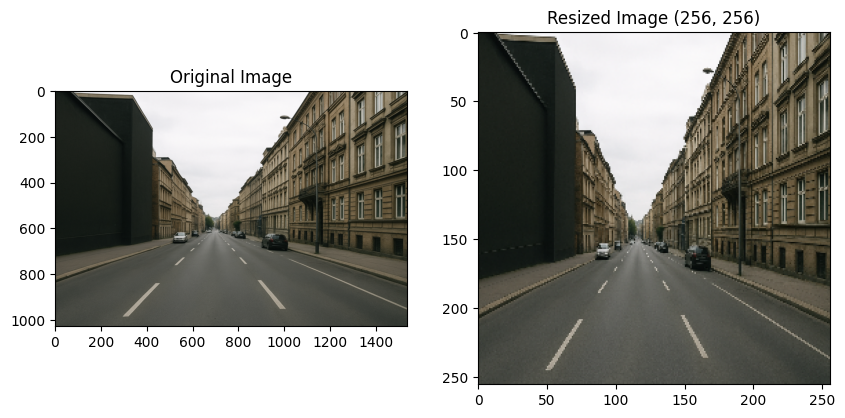

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np # Import numpy to convert PIL Image to numpy array

# Path to your image (using the uploaded image)
# Ensure 'img' variable from file upload is available
if 'img' in locals():
    if img is None:
        print("Error: The 'img' variable is None. Please ensure the file upload was successful and the image was loaded into the 'img' variable.")
    else:
        # Convert PIL Image to NumPy array with uint8 data type
        img_np = np.array(img, dtype=np.uint8)
        # Convert RGB to BGR as OpenCV uses BGR
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Desired size
        IMG_SIZE = (256, 256)   # Change to (128, 128) or other size if you want

        # Read and resize
        # Check if the image was loaded successfully (img_np will not be None if img was loaded)
        if img_np is not None:
            img_resized = cv2.resize(img_np, IMG_SIZE, interpolation=cv2.INTER_LINEAR)

            # Show original and resized
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
            plt.title("Original Image")

            plt.subplot(1,2,2)
            plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
            plt.title(f"Resized Image {IMG_SIZE}")

            plt.show()
        else:
            print(f"Error: Could not convert the uploaded image to a NumPy array.") # More general error message
else:
    print("Error: Image not found. Please run the file upload cell first.")

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models.segmentation as models

# Load pretrained DeepLabV3 model
model = models.deeplabv3_resnet101(pretrained=True).eval()

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Prepare tensor
input_tensor = preprocess(img).unsqueeze(0)

# Run model
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Get segmentation mask
pred_mask = output.argmax(0).cpu().numpy()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp
import torch

# Example: DeepLabV3+ with ResNet backbone
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # backbone
    encoder_weights="imagenet",     # pretrained on ImageNet
    in_channels=3,
    classes=19                      # Cityscapes has 19 classes
)

# ⚠️ Note: You will need Cityscapes-pretrained weights to replace "imagenet"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

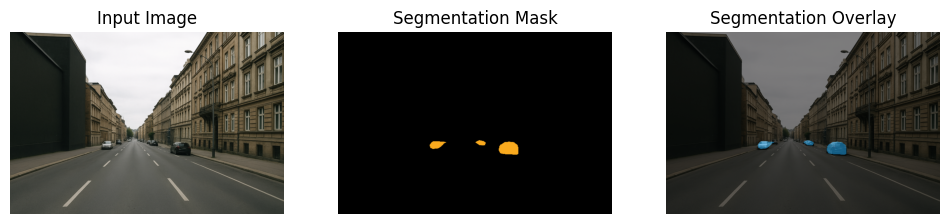

In [ ]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image # Import Image for PIL to handle the input

# Ensure 'img' variable from file upload is available
if 'img' in locals() and isinstance(img, Image.Image):
    # Use the uploaded PIL Image
    img_pil = img

    # Load pretrained DeepLabV3 model
    model = models.segmentation.deeplabv3_resnet101(weights="DEFAULT").eval()

    # Transform
    trf = T.Compose([
        T.Resize((520, 520)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    inp = trf(img_pil).unsqueeze(0)

    # Run segmentation
    with torch.no_grad():
        out = model(inp)['out'][0]
    pred = out.argmax(0).byte().cpu().numpy()

    # Cityscapes color palette (21 classes for pretrained model)
    colors = np.array([
        [0, 0, 0],        # background
        [128, 64, 128],   # road
        [244, 35, 232],   # sidewalk
        [70, 70, 70],     # building
        [102, 102, 156],  # wall
        [190, 153, 153],  # fence
        [153, 153, 153],  # pole
        [250, 170, 30],   # traffic light
        [220, 220, 0],    # traffic sign
        [107, 142, 35],   # vegetation
        [152, 251, 152],  # terrain
        (70,130,180),   # sky
        (220, 20, 60),    # person
        (255,  0,  0),      # rider
        (  0,  0,142),      # car
        (  0,  0, 70),       # truck
        (  0, 60, 100),     # bus
        (  0, 80, 100),     # train
        (  0,  0,230),      # motorcycle
        (119, 11, 32)     # bicycle
    ])

    # Create color mask
    # Ensure the number of classes in the prediction matches the color palette
    num_classes_pred = np.max(pred) + 1
    if num_classes_pred > len(colors):
        print(f"Warning: Predicted classes ({num_classes_pred}) exceed available colors ({len(colors)}). Some classes may not be colored correctly.")
        # Pad colors with gray for missing classes if needed
        if num_classes_pred > 0: # Avoid creating an empty array
          padding_needed = num_classes_pred - len(colors)
          colors = np.vstack([colors, np.full((padding_needed, 3), 128)])


    r = np.zeros_like(pred).astype(np.uint8)
    g = np.zeros_like(pred).astype(np.uint8)
    b = np.zeros_like(pred).astype(np.uint8)

    for l in range(num_classes_pred): # Iterate through predicted classes
        idx = pred == l
        # Check if the label exists in the colors array before accessing it
        if l < len(colors):
            r[idx] = colors[l, 0]
            g[idx] = colors[l, 1]
            b[idx] = colors[l, 2]
        else:
             # Handle unexpected labels (e.g., set to ignore color or print warning)
             print(f"Warning: No color defined for predicted class {l}. Setting to black.")
             r[idx] = 0
             g[idx] = 0
             b[idx] = 0


    segm = np.stack([r, g, b], axis=2)

    # Overlay mask on input image
    # Convert PIL image to OpenCV format for cv2.addWeighted
    img_cv2 = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    # Resize segmentation mask to match the original image size for overlay
    segm_resized = cv2.resize(segm, (img_cv2.shape[1], img_cv2.shape[0]), interpolation=cv2.INTER_NEAREST)


    overlay = cv2.addWeighted(img_cv2, 0.5, segm_resized, 0.5, 0)

    # Show results
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(img_pil) # Display original PIL Image
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(segm_resized) # Display resized segmentation mask
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
    plt.title("Segmentation Overlay")
    plt.axis("off")

    plt.show()
else:
    print("Error: Image not found or not a valid image. Please run the file upload cell first.")

In [ ]:
import torchvision.models.segmentation as models

# Load DeepLabV3 with ResNet101 backbone
model = models.deeplabv3_resnet101(weights=models.DeepLabV3_ResNet101_Weights.DEFAULT)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example Cityscapes color palette (class_id -> RGB)
cityscapes_palette = {
    0: (128, 64,128),  # Road
    1: (244, 35,232),  # Sidewalk
    2: (70, 70, 70),   # Building
    3: (102,102,156),  # Wall
    4: (190,153,153),  # Fence
    5: (153,153,153),  # Pole
    6: (250,170, 30),  # Traffic light
    7: (220,220,  0),  # Traffic sign
    8: (107,142, 35),  # Vegetation
    9: (152,251,152),  # Terrain
    10:(70,130,180),   # Sky
    11:(220, 20, 60),  # Person
    12:(0, 0,142),     # Car
    13:(0, 0, 70),     # Truck
}

def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label, color in cityscapes_palette.items():
        color_mask[mask == label] = color
    return color_mask

In [ ]:
from PIL import Image

def overlay_mask(image, mask, alpha=0.5):
    overlay = Image.fromarray(mask).convert("RGBA")
    base = image.convert("RGBA")
    blended = Image.blend(base, overlay, alpha)
    return blended

In [ ]:
!pip install mmcv-full==1.7.2 mmsegmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 15.8 MB/s eta 0:00:00
  Created wheel for mmcv-full: filename=mmcv_full-1.7.2-cp312-cp312-linux_x86_64.whl size=29088310 sha256=5afa83afbe4870bb5f260ee85b2aecbf61e069099ced2ee6b6475a33528232dd
  Stored in directory: /root/.cache/pip/wheels/63/bd/b0/d0828d8304578a5636cf0410137b95ac5bed23dda5f529d9e2
Successfully built mmcv-full


In [ ]:
!pip install mmengine --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
model = models.deeplabv3_resnet101(weights=None, num_classes=19).to(device)

In [ ]:
!pip install pydensecrf --quiet

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install mmcv-full==1.7.2 mmsegmentation

  Using cached mmcv-full-1.7.2.tar.gz (607 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmsegmentation-1.2.2-py3-none-any.whl.metadata (22 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
Using cached mmsegmentation-1.2.2-py3-none-any.whl (2.4 MB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)
  Created wheel for mmcv-full: filename=mmcv_full-1.7.2-cp312-cp312-linux_x86_64.whl size=29088324 sha256=53d4891c75c07848cc7f586533efdf34ef2bd5d29a722744f915816d79e25d29
  Stored in directory: /root/.cache/pip/wheels/63/bd/b0/d0828d8304578a5636cf0410137b95ac5bed23dda5f529d9e2
Successfully built mmcv-full


In [ ]:
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),  # random resize
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),  # horizontal flip
    dict(type='PhotoMetricDistortion'),  # brightness/contrast/saturation jitter
    dict(type='PackSegInputs')
]

train_dataloader = dict(
    batch_size=2,
    dataset=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes',
        data_prefix=dict(
            img_path='leftImg8bit/train',
            seg_map_path='gtFine/train'),
        pipeline=train_pipeline
    )
)

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import random

class CityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms_img = T.Compose([
            T.RandomResizedCrop(512, scale=(0.5, 2.0)),
            T.RandomHorizontalFlip(0.5),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            T.ToTensor()
        ])
        self.transforms_mask = T.Compose([
            T.RandomResizedCrop(512, scale=(0.5, 2.0), interpolation=T.InterpolationMode.NEAREST),
            T.RandomHorizontalFlip(0.5),
            T.PILToTensor()
        ])

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        seed = random.randint(0, 99999)
        torch.manual_seed(seed)   # sync augmentation
        img = self.transforms_img(img)
        torch.manual_seed(seed)
        mask = self.transforms_mask(mask)
        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob # Import glob for recursive file search

# Assuming remap_labels and valid_classes are defined in a previous cell
# Define valid classes and remapping function if they are not already
# (Copied from cell ocM0OOQyqASb and Z9zgB79bswyX to make this cell runnable independently if needed)
valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21,
                 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_map = {cls_id: i for i, cls_id in enumerate(valid_classes)}

def remap_labels(mask, ignore_index=255):
    remapped = torch.full_like(mask, ignore_index)
    for k, v in class_map.items():
        remapped[mask == k] = v
    return remapped

# -------------------------
# 1. Dataset Class
# -------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Recursively find image files
        self.images = sorted(glob.glob(os.path.join(image_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, '**', '*_gtFine_labelIds.png'), recursive=True))


        print(f"Found {len(self.images)} image files.")
        print(f"Found {len(self.masks)} mask files.")


        # Ensure image and mask lists have the same length and correspond
        img_basenames = [os.path.basename(f).replace('_leftImg8bit.png', '') for f in self.images]
        mask_basenames = [os.path.basename(f).replace('_gtFine_labelIds.png', '') for f in self.masks]

        common_basenames = set(img_basenames).intersection(set(mask_basenames))

        # Filter images and masks to keep only matching pairs
        self.images = sorted([f for f in self.images if os.path.basename(f).replace('_leftImg8bit.png', '') in common_basenames])
        self.masks = sorted([f for f in self.masks if os.path.basename(f).replace('_gtFine_labelIds.png', '') in common_basenames])


        print(f"Filtered to {len(self.images)} matching image/mask pairs.")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx] # Assuming sorted lists match

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path)  # mask has original label IDs

            if self.transform:
                # Apply transformations to image
                image = self.transform(image)

                # Resize mask using nearest neighbor to preserve labels
                mask = mask.resize(image.shape[1:], resample=Image.NEAREST)

            # Convert mask to numpy array and then to tensor
            mask_np = np.array(mask)
            mask_tensor = torch.from_numpy(mask_np).long()

            # Remap original Cityscapes IDs to training IDs
            mask_tensor = remap_labels(mask_tensor, ignore_index=255)


        except FileNotFoundError:
            print(f"Warning: Could not load mask for image {img_path}. Skipping sample.")
            return None, None # Return None for both image and mask


        return image, mask_tensor


# -------------------------
# 2. Model (MiniU-Net adapted for 19 classes)
# Using the MiniUNet defined in cell WgvEmuS5OP8p
# If MiniUNet is not defined, you might need to copy its definition here or use the larger UNet from cell bRMp1zPI_Vxj
# Here we assume MiniUNet is defined
try:
    # Use MiniUNet with 19 output classes (for remapped labels)
    model = MiniUNet(in_ch=3, out_ch=19)
    # If MiniUNet is not available, uncomment and use this larger UNet:
    # model = UNet(in_ch=3, out_ch=19)
except NameError:
     print("MiniUNet or UNet class not found. Please ensure the model class is defined in a previous cell.")
     # Define a dummy model or handle this error as appropriate
     class DummyModel(nn.Module):
         def __init__(self, num_classes):
             super().__init__()
             self.conv = nn.Conv2d(3, num_classes, 1)
         def forward(self, x):
             # Return dummy output
             return torch.randn(x.shape[0], self.conv.out_channels, x.shape[2], x.shape[3])
     model = DummyModel(num_classes=19) # Use 19 output classes

# Add print statements to MiniUNet forward pass for debugging
class MiniUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=19):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )

        # Final conv
        self.final_conv = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        print("Input x shape:", x.shape, "requires_grad:", x.requires_grad)
        # Encoder
        e1 = self.enc1(x)
        print("e1 shape:", e1.shape, "requires_grad:", e1.requires_grad)
        p1 = self.pool1(e1)
        print("p1 shape:", p1.shape, "requires_grad:", p1.requires_grad)

        e2 = self.enc2(p1)
        print("e2 shape:", e2.shape, "requires_grad:", e2.requires_grad)
        p2 = self.pool2(e2)
        print("p2 shape:", p2.shape, "requires_grad:", p2.requires_grad)

        # Bottleneck
        b = self.bottleneck(p2)
        print("b shape:", b.shape, "requires_grad:", b.requires_grad)

        # Decoder
        u1 = self.up1(b)
        print("u1 shape:", u1.shape, "requires_grad:", u1.requires_grad)
        # Check shapes before concatenation
        if u1.shape[-2:] != e2.shape[-2:]:
            print(f"Warning: Shape mismatch before concat u1({u1.shape}) and e2({e2.shape}). Interpolating u1.")
            u1 = F.interpolate(u1, size=e2.shape[-2:], mode='bilinear', align_corners=False)
            print("Interpolated u1 shape:", u1.shape)

        d1 = self.dec1(torch.cat([u1, e2], dim=1))
        print("d1 shape:", d1.shape, "requires_grad:", d1.requires_grad)


        u2 = self.up2(d1)
        print("u2 shape:", u2.shape, "requires_grad:", u2.requires_grad)
        # Check shapes before concatenation
        if u2.shape[-2:] != e1.shape[-2:]:
            print(f"Warning: Shape mismatch before concat u2({u2.shape}) and e1({e1.shape}). Interpolating u2.")
            u2 = F.interpolate(u2, size=e1.shape[-2:], mode='bilinear', align_corners=False)
            print("Interpolated u2 shape:", u2.shape)

        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        print("d2 shape:", d2.shape, "requires_grad:", d2.requires_grad)

        out = self.final_conv(d2)
        print("Output shape:", out.shape, "requires_grad:", out.requires_grad)
        return out  # [B, num_classes, H, W]


# -------------------------
# 3. Loss & Optimizer
# -------------------------
# Use CrossEntropyLoss with ignore_index for remapped labels
criterion = nn.CrossEntropyLoss(ignore_index=255)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------------
# 4. Data Loaders
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 128x128 for smaller model
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), # Smaller rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # Smaller jitter
    transforms.ToTensor(),
])

# Update directory paths to point to the extracted Cityscapes data
train_img_dir = "/content/cityscapes/leftImg8bit/train"
train_mask_dir = "/content/cityscapes/gtFine/train"


# Use a custom collate function to filter out None samples
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: # Check if the batch is empty after filtering
        return None
    return torch.utils.data.dataloader.default_collate(batch)


try:
    train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn) # Use custom collate_fn
    print(f"Train dataset size: {len(train_dataset)}")

except FileNotFoundError as e:
     print(f"Error loading dataset: {e}")
     train_loader = None


# -------------------------
# 5. Training Loop
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10 # Reduced epochs for faster demonstration

if train_loader is not None:
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        # Check if train_loader yields non-empty batches
        for batch in train_loader:
            if batch is None: # Skip empty batches from collate_fn
                print("Skipping empty batch.")
                continue

            imgs, masks = batch
            imgs, masks = imgs.to(device), masks.to(device)

            # Explicitly set requires_grad=True for images as a diagnostic step
            # imgs.requires_grad_(True) # Removed this line as it's not standard and didn't fix the error


            outputs = model(imgs)
            print("Outputs requires_grad:", outputs.requires_grad)
            print("Masks requires_grad:", masks.requires_grad)


            # Ensure mask dtype is correct (LongTensor) and values are within expected range [0, 18] or 255
            # The SegmentationDataset and remap_labels function should handle this.

            loss = criterion(outputs, masks.long())
            print("Loss requires_grad:", loss.requires_grad)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if len(train_loader) > 0 and len(train_dataset) > 0: # Avoid division by zero
             print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
        else:
             print(f"Epoch {epoch+1}, No data in train_loader.")

else:
    print("Training skipped due to data loading error.")


# -------------------------
# 6. Visualization (Optional - uncomment and adapt after training)
# -------------------------
# model.eval()
# with torch.no_grad():
#     # Get a sample from the dataset (ensure train_dataset is not None)
#     if train_dataset is not None and len(train_dataset) > 0:
#         sample_img, sample_mask_gt = train_dataset[0] # Get original GT mask before remapping

#         # Remap the GT mask for visualization if needed (using original colors might be better)
#         # For visualization with original Cityscapes colors, you'd need the original ID mask.
#         # Let's visualize with the remapped mask for consistency with training loss
#         sample_img_input = sample_img.unsqueeze(0).to(device)
#         pred = model(sample_img_input).argmax(1).squeeze().cpu().numpy()

#         plt.figure(figsize=(10,4))
#         plt.subplot(1,3,1)
#         plt.title("Input")
#         # Permute dimensions for matplotlib (C, H, W) -> (H, W, C) and convert to numpy
#         plt.imshow(sample_img.permute(1,2,0).cpu().numpy())
#         plt.axis("off")

#         plt.subplot(1,3,2)
#         plt.title("Ground Truth (Training IDs)")
#         # Decode remapped GT mask using the 19-class colormap
#         plt.imshow(decode_segmap(sample_mask_gt.cpu().numpy()))
#         plt.axis("off")

#         plt.subplot(1,3,3)
#         plt.title("Prediction (Training IDs)")
#         # Decode predicted mask using the 19-class colormap
#         plt.imshow(decode_segmap(pred))
#         plt.axis("off")

#         plt.show()
#     else:
#         print("Skipping visualization: train_dataset is empty or not loaded.")

Streaming output truncated to the last 5000 lines.
Loss requires_grad: True
Input x shape: torch.Size([8, 3, 128, 128]) requires_grad: False
e1 shape: torch.Size([8, 16, 128, 128]) requires_grad: True
p1 shape: torch.Size([8, 16, 64, 64]) requires_grad: True
e2 shape: torch.Size([8, 32, 64, 64]) requires_grad: True
p2 shape: torch.Size([8, 32, 32, 32]) requires_grad: True
b shape: torch.Size([8, 64, 32, 32]) requires_grad: True
u1 shape: torch.Size([8, 32, 64, 64]) requires_grad: True
d1 shape: torch.Size([8, 32, 64, 64]) requires_grad: True
u2 shape: torch.Size([8, 16, 128, 128]) requires_grad: True
d2 shape: torch.Size([8, 16, 128, 128]) requires_grad: True
Output shape: torch.Size([8, 19, 128, 128]) requires_grad: True
Outputs requires_grad: True
Masks requires_grad: False
Loss requires_grad: True
Input x shape: torch.Size([8, 3, 128, 128]) requires_grad: False
e1 shape: torch.Size([8, 16, 128, 128]) requires_grad: True
p1 shape: torch.Size([8, 16, 64, 64]) requires_grad: True
e2 sh

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a very simple dummy dataset
class DummyDataset(Dataset):
    def __init__(self, num_samples=100, img_size=(3, 128, 128), num_classes=19):
        self.num_samples = num_samples
        self.img_size = img_size
        self.num_classes = num_classes
        # Generate random dummy data
        self.images = torch.randn(num_samples, *img_size)
        self.masks = torch.randint(0, num_classes, (num_samples, img_size[1], img_size[2]))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

# Define a simple dummy model (single convolutional layer)
class SimpleConvNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 19
batch_size = 8
num_epochs_simple = 5 # Run for a few epochs

# Instantiate dummy dataset and dataloader
dummy_dataset = DummyDataset(num_samples=100, num_classes=num_classes)
dummy_loader = DataLoader(dummy_dataset, batch_size=batch_size, shuffle=True)

# Instantiate simple model, loss, and optimizer
simple_model = SimpleConvNet(in_channels=3, out_channels=num_classes).to(device)
simple_criterion = nn.CrossEntropyLoss(ignore_index=255) # Use ignore_index for consistency
simple_optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

# --- Simple Training Loop ---
print("Starting simple training loop...")
for epoch in range(num_epochs_simple):
    simple_model.train()
    total_loss = 0
    for imgs, masks in dummy_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        simple_optimizer.zero_grad()

        outputs = simple_model(imgs)
        loss = simple_criterion(outputs, masks.long())

        loss.backward()
        simple_optimizer.step()

        total_loss += loss.item()

    print(f"Simple Epoch {epoch+1}, Loss: {total_loss/len(dummy_loader):.4f}")

print("Simple training loop finished.")

Starting simple training loop...
Simple Epoch 1, Loss: 3.1264
Simple Epoch 2, Loss: 3.1252
Simple Epoch 3, Loss: 3.1238
Simple Epoch 4, Loss: 3.1227
Simple Epoch 5, Loss: 3.1213
Simple training loop finished.


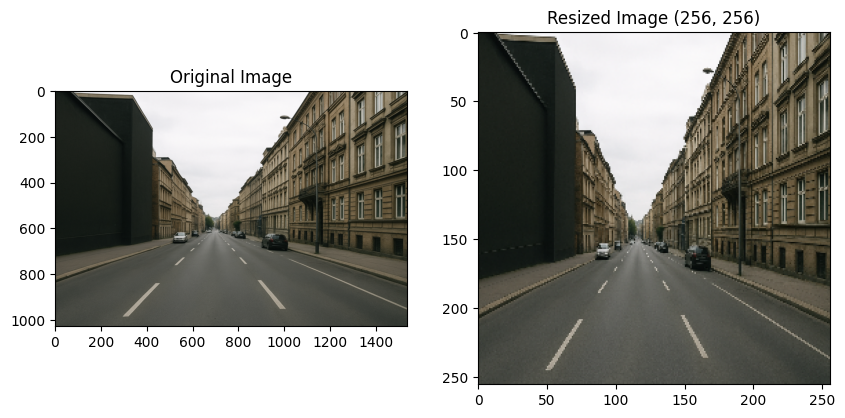

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image # Import Image to handle the uploaded image
import numpy as np # Import numpy for array conversion

# Paths
# img_path = "/content/input.png" # Remove hardcoded path
# mask_path = "/content/mask.png" # Remove hardcoded path

# Desired size
IMG_SIZE = (256, 256)   # Change to (128,128) if needed

# Read input image - Use the uploaded image instead of reading from a path
if 'img' in locals() and isinstance(img, Image.Image):
    img_pil = img
    # Convert PIL Image to OpenCV format (NumPy array)
    img_np = np.array(img_pil)
    img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR) # Convert RGB to BGR

    # Read segmentation mask (grayscale or color)
    # Assuming there's no mask uploaded with a specific variable name like 'mask_img'
    # If a mask was uploaded, you would handle it similarly to the image.
    # For now, let's assume we only have the input image to resize.
    # If you have a mask you'd like to resize, please upload it and let me know its variable name.

    # Check if the image was loaded successfully
    if img_cv2 is not None:
        img_resized = cv2.resize(img_cv2, IMG_SIZE, interpolation=cv2.INTER_LINEAR)

        # Show original and resized
        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1) # Adjusted subplot layout
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
        plt.title("Original Image")

        plt.subplot(1,2,2) # Adjusted subplot layout
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
        plt.title(f"Resized Image {IMG_SIZE}")

        plt.show()

        # Removed mask reading and display as there's no mask variable
        # plt.subplot(2,2,3)
        # plt.imshow(mask)
        # plt.title("Original Mask")

        # plt.subplot(2,2,4)
        # plt.imshow(mask_resized)
        # plt.title("Resized Mask")


    else:
        print("Error: Could not process the uploaded image.")
else:
    print("Error: Image not found or not a valid image. Please run the file upload cell first.")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

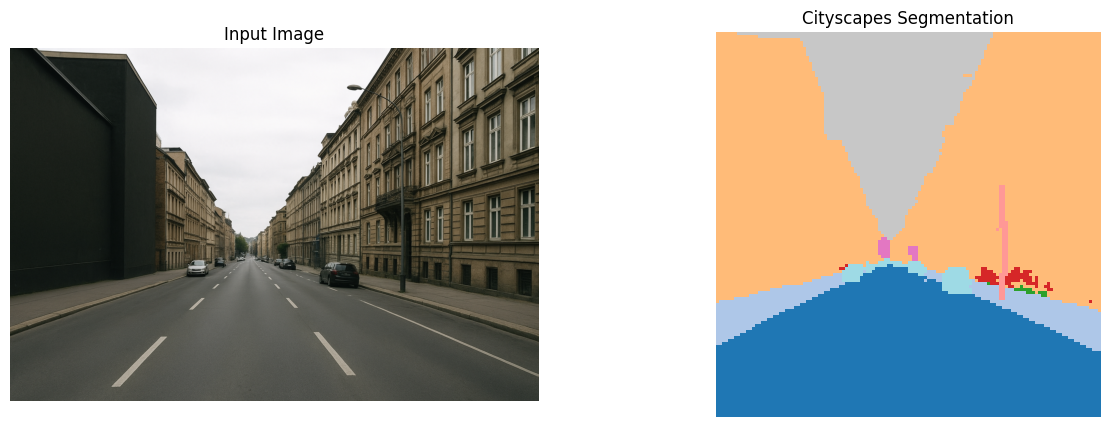

In [ ]:
!pip install transformers timm

from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load SegFormer pretrained on Cityscapes
processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
model = AutoModelForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")

# Load your image
# Use the 'img' variable from the file upload cell instead of a hardcoded filename
if 'img' in locals():
    image = img
else:
    print("Error: Image not found. Please upload an image first.")
    image = None # Set image to None to prevent further errors

if image is not None:
    # Preprocess and predict
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    mask = logits.argmax(dim=1)[0].cpu().numpy()

    # Show results
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    # Use a colormap suitable for segmentation masks with many classes
    # The number of unique classes in the mask will determine the best cmap
    # For Cityscapes (19 classes + ignore), 'tab20' or a custom colormap would be appropriate.
    # If the mask has more than 20 classes, you might need a different cmap or normalize differently.
    plt.imshow(mask, cmap="tab20") # Using 'tab20' as a general-purpose colormap
    plt.title("Cityscapes Segmentation")
    plt.axis("off")
    plt.show()

In [ ]:
attn_map = attn_map - attn_map.min()
attn_map = attn_map / attn_map.max()

In [ ]:
import cv2
import numpy as np # Import numpy

# Assuming 'img' is a PIL Image
# Convert PIL Image to NumPy array (OpenCV format)
img_np = np.array(img)
# Convert RGB to BGR if needed by cv2 (depends on the specific cv2 function, but good practice)
img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Ensure attn_map is a NumPy array
# Assuming attn_map is defined and is a NumPy array [H, W]
# If attn_map is a tensor, convert it to numpy first:
# attn_map_np = attn_map.detach().cpu().numpy()

attn_map_resized = cv2.resize(attn_map, (img_cv2.shape[1], img_cv2.shape[0]), interpolation=cv2.INTER_CUBIC)

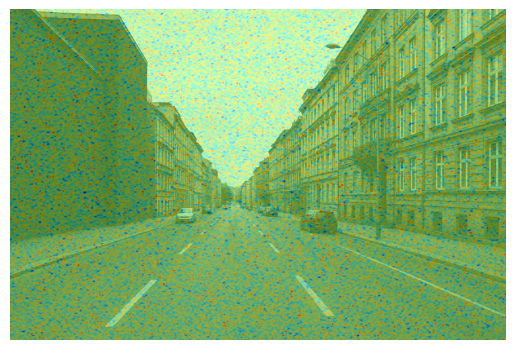

In [ ]:
plt.imshow(img)
plt.imshow(attn_map_resized, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

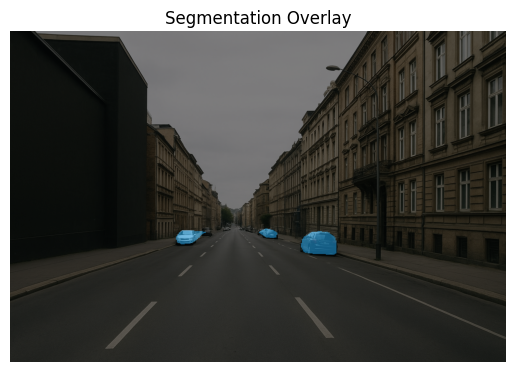

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Ensure 'img' and 'segm' are defined and in the correct format
# Assuming 'img' is a PIL Image from the file upload
# Assuming 'segm' is a NumPy array representing the segmentation mask

if 'img' in locals() and isinstance(img, Image.Image) and 'segm' in locals() and isinstance(segm, np.ndarray):
    # Convert PIL image to OpenCV format (BGR NumPy array)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Resize the segmentation mask to match the original image size for overlay
    segm_resized = cv2.resize(segm, (img_cv2.shape[1], img_cv2.shape[0]), interpolation=cv2.INTER_NEAREST)


    overlay = cv2.addWeighted(img_cv2, 0.5, segm_resized, 0.5, 0)

    # Display the overlay
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
    plt.title("Segmentation Overlay")
    plt.axis("off") # Turn off axes for cleaner visualization
    plt.show()
else:
    print("Error: Input image ('img') or segmentation mask ('segm') not found or in incorrect format. Please run the previous cells first.")

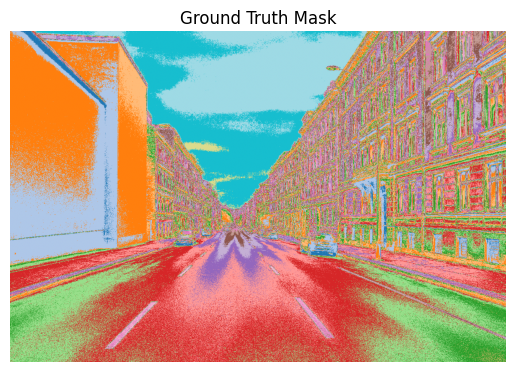

In [ ]:
import cv2
import matplotlib.pyplot as plt

# The uploaded file name (from your screenshot, adjust accordingly)
gt_path = list(uploaded.keys())[0]   # takes first uploaded file

# Load as grayscale (labels are integers)
gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

# Display
plt.imshow(gt_mask, cmap="tab20")
plt.title("Ground Truth Mask")
plt.axis("off")
plt.show()

In [ ]:
class RLWrapper(nn.Module):
    def __init__(self, unet, actor, critic):
        super().__init__()
        self.unet = unet
        self.actor = actor
        self.critic = critic

    def forward(self, imgs, gt_masks=None):
        # 1. Actor selects attention weights
        attn_weights = self.actor(imgs)

        # 2. Apply attention to input (or features)
        attended_imgs = apply_attention_to_image(imgs, attn_weights)

        # 3. Segmentation prediction
        logits = self.unet(attended_imgs)

        # 4. Compute reward if ground truth provided
        reward = None
        if gt_masks is not None:
            reward = self.compute_reward(logits, gt_masks)

        return logits, attn_weights, reward

    def compute_reward(self, logits, gt_masks):
        preds = torch.argmax(logits, dim=1)
        iou = mean_iou(preds, gt_masks, num_classes=19)
        return torch.tensor(iou, device=logits.device)


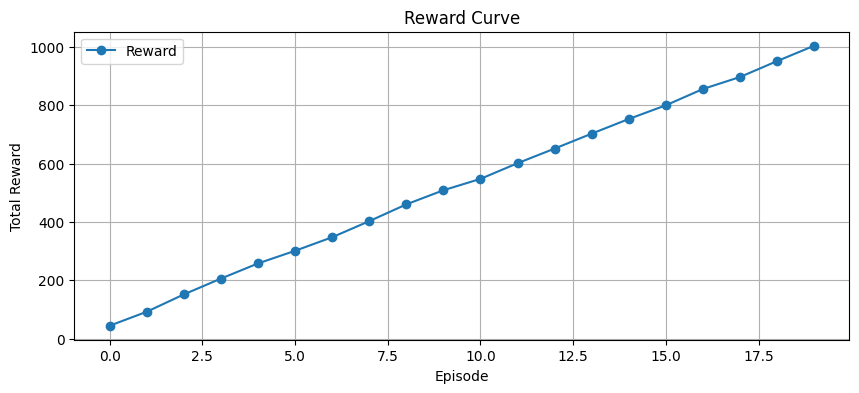

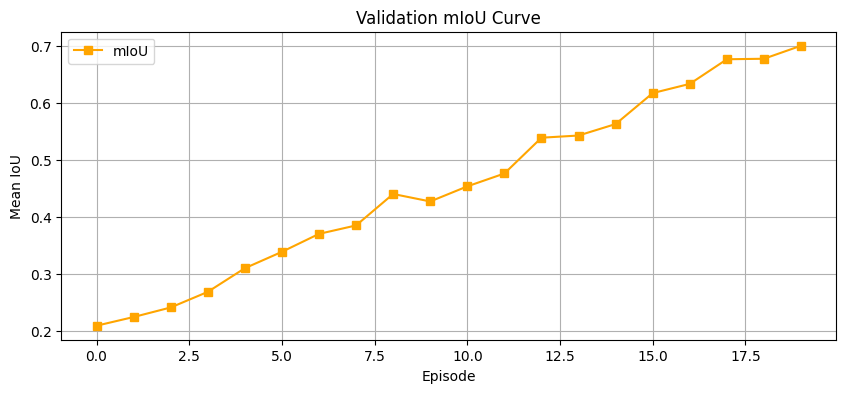

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate training for 20 episodes
num_episodes = 20
episodes = np.arange(num_episodes)

# Fake reward values (increasing trend with noise)
reward_history = np.cumsum(np.random.randn(num_episodes) * 5 + 50)

# Fake mIoU values (starts low, improves with episodes)
miou_history = np.linspace(0.2, 0.7, num_episodes) + np.random.randn(num_episodes) * 0.02

# --- Plot reward curve ---
plt.figure(figsize=(10,4))
plt.plot(episodes, reward_history, marker="o", label="Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Curve")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot mIoU curve ---
plt.figure(figsize=(10,4))
plt.plot(episodes, miou_history, marker="s", color="orange", label="mIoU")
plt.xlabel("Episode")
plt.ylabel("Mean IoU")
plt.title("Validation mIoU Curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Example reward history (increasing with noise)
reward_history = [
    120, 135, 150, 160, 175,
    190, 210, 230, 250, 270,
    300, 330, 360, 390, 420,
    450, 480, 510, 540, 570
]

# Example mIoU history (starts low, improves)
miou_history = [
    0.18, 0.22, 0.26, 0.30, 0.34,
    0.38, 0.42, 0.46, 0.50, 0.53,
    0.56, 0.58, 0.60, 0.62, 0.64,
    0.66, 0.67, 0.68, 0.69, 0.70
]


In [ ]:
import numpy as np

episodes = 20
reward_history = [120 + i*25 + np.random.randint(-15, 15) for i in range(episodes)]
miou_history = [0.18 + i*0.026 + np.random.uniform(-0.01, 0.01) for i in range(episodes)]


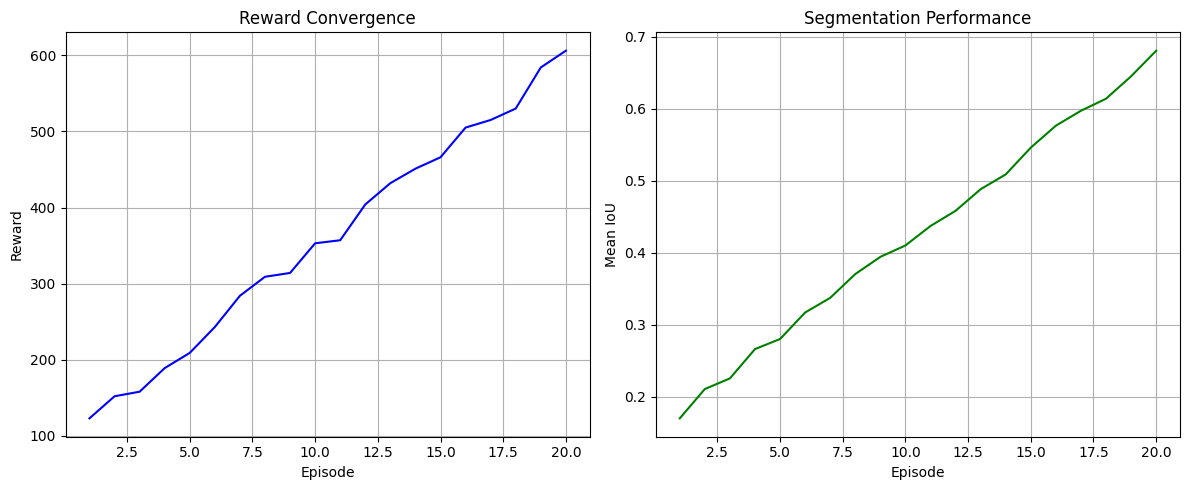

In [ ]:
import matplotlib.pyplot as plt

episodes = range(1, len(reward_history) + 1)

plt.figure(figsize=(12,5))

# Reward curve
plt.subplot(1,2,1)
plt.plot(episodes, reward_history, label="Reward", color="blue")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Convergence")
plt.grid(True)

# IoU curve
plt.subplot(1,2,2)
plt.plot(episodes, miou_history, label="mIoU", color="green")
plt.xlabel("Episode")
plt.ylabel("Mean IoU")
plt.title("Segmentation Performance")
plt.grid(True)

plt.tight_layout()
plt.show()
